### Import Library

In [1]:
import os
import torch
import torchvision
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torchvision import transforms, datasets, models
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
from torch.utils.data import DataLoader
import timm
import copy
from torch.optim import lr_scheduler

### Device Selection

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Data Preprocessing

In [4]:
# Define transformations for the images
# For grayscale images, ensure transform handles 1 channel or converts to 3 channels if needed by model
# Most pre-trained models expect 3-channel input, so we'll convert grayscale to 3 channels.
data_transforms = {
    'training': transforms.Compose([
        transforms.Resize((224, 224)), # Resize all images to 224x224
        transforms.Grayscale(num_output_channels=3), # Convert grayscale to 3 channels
        transforms.RandomHorizontalFlip(), # Data augmentation
        transforms.RandomRotation(10), # Data augmentation
        transforms.ToTensor(), # Convert PIL Image to Tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalize with ImageNet stats
    ]),
    'validation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Path to your dataset
data_dir = r"C:\Users\Administrator\dl_env\Deep Learning\data" # Assuming your 'data' folder is in the same directory as your notebook

# Create datasets
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['training', 'validation', 'test']
}

# Create data loaders
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=32, shuffle=(x == 'training'), num_workers=4)
    for x in ['training', 'validation', 'test']
}

# Dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['training', 'validation', 'test']}

# Class names
class_names = image_datasets['training'].classes
NUM_CLASSES = len(class_names)
print(f"Class names: {class_names}")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Dataset sizes: {dataset_sizes}")

# Get test loader for evaluation
test_loader = dataloaders['test']

Class names: ['abn', 'bmt', 'malg', 'nml', 'stn']
Number of classes: 5
Dataset sizes: {'training': 1605, 'validation': 346, 'test': 343}


### Model Setup

In [25]:
def get_model(name, num_classes):
    """Initializes and returns a pre-trained model with a modified head or a custom model."""
    model = None
    if name == "resnet18":
        model = torchvision.models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif name == "efficientnet_b0":
        model = torchvision.models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif name == "densenet121":
        model = torchvision.models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    elif name == "mobilenet_v2":
        model = torchvision.models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif name == "shufflenet_v2":
        model = torchvision.models.shufflenet_v2_x1_0(weights=models.ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif name == "squeezenet":
        model = torchvision.models.squeezenet1_0(weights=models.SqueezeNet1_0_Weights.IMAGENET1K_V1)
        # SqueezeNet's classifier is a Conv2d layer; modify the last one
        model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model.num_classes = num_classes # Ensure the model knows its num_classes
    # --- Previously Added Models --- #
    elif name == "densenet201":
        model = torchvision.models.densenet201(weights=models.DenseNet201_Weights.IMAGENET1K_V1)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    elif name == "efficientnet_b1":
        model = torchvision.models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.IMAGENET1K_V1)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif name == "efficientnet_b2":
        model = torchvision.models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.IMAGENET1K_V1)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif name == "efficientnet_b3":
        model = torchvision.models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif name == "efficientnet_b4":
        model = torchvision.models.efficientnet_b4(weights=models.EfficientNet_B4_Weights.IMAGENET1K_V1)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif name == "resnet50_v1": # ResNet50_V1 refers to common ResNet50
        model = torchvision.models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif name == "resnet50_v2": # ResNet50_V2 refers to deeper/different ResNet50 variants if available, here using V2 weights
        model = torchvision.models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    # --- New Models to Add: GBCNet and RadFormer --- #
    elif name == "gbcnet":
        model = GBCNet(num_classes)
    elif name == "radformer":
        # Using a pre-trained ViT from timm as a representation of RadFormer
        # Common ViT models: 'vit_base_patch16_224', 'vit_small_patch16_224'
        # We'll use 'vit_base_patch16_224' and modify its head.
        model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)
        # timm models automatically adjust the head if num_classes is passed to create_model
    else:
        raise ValueError(f"Model '{name}' not supported.")
    return model.to(device)

### Training Function

In [26]:
def train_model(model, model_name, epochs=25, patience=5):
    """
    Trains the given model, including early stopping.

    Args:
        model: The PyTorch model to train.
        model_name (str): Name of the model for logging and plotting.
        epochs (int): Maximum number of training epochs.
        patience (int): Number of epochs to wait for improvement before early stopping.

    Returns:
        tuple: (trained_model, train_loss_history, val_loss_history,
                train_acc_history, val_acc_history)
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) # Learning rate scheduler

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epochs_no_improve = 0
    early_stop = False

    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    print(f"\n--- Training {model_name} ---")
    for epoch in range(epochs):
        if early_stop:
            print("Early stopping triggered.")
            break

        print(f'Epoch {epoch}/{epochs - 1}')
        print('-' * 10)

        for phase in ['training', 'validation']:
            if phase == 'training':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'training'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'training':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'training':
                scheduler.step() # Step the scheduler after training phase

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'training':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

                # Deep copy the model if it's the best validation accuracy
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                    if epochs_no_improve == patience:
                        early_stop = True

    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

### Evaluation Functions

In [27]:
def evaluate_model_on_test(model, model_name):
    """Evaluates the model on the test set and returns predictions."""
    model.eval()
    y_true = []
    y_pred_classes = []
    y_pred_scores = [] # Store probabilities/scores for ROC curve

    print(f"\n--- Evaluating {model_name} on Test Set ---")
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred_classes.extend(preds.cpu().numpy())
            y_pred_scores.extend(probabilities.cpu().numpy())

    test_accuracy = accuracy_score(y_true, y_pred_classes)
    model_results[model_name] = test_accuracy # Store accuracy in global dict
    print(f"Test Accuracy for {model_name}: {test_accuracy:.4f}")
    print(f"Classification Report for {model_name}:\n{classification_report(y_true, y_pred_classes, target_names=class_names)}")
    return y_true, y_pred_classes, np.array(y_pred_scores)


def ensemble_evaluate(models, test_loader, class_names, device):
    """
    Performs ensemble prediction on the test set by averaging probabilities.
    """
    print("\n--- Performing Ensemble Evaluation ---")
    ensemble_probs = []
    y_true = []

    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        y_true.extend(labels.cpu().numpy())

        # Get predictions from each model
        model_outputs = []
        for model in models:
            model.eval() # Set model to evaluation mode
            with torch.no_grad():
                outputs = model(inputs)
                model_outputs.append(torch.softmax(outputs, dim=1).cpu().numpy())

        # Average the probabilities
        avg_probs = np.mean(model_outputs, axis=0)
        ensemble_probs.extend(avg_probs)

    ensemble_probs = np.array(ensemble_probs)
    y_pred_ensemble_classes = np.argmax(ensemble_probs, axis=1)

    ensemble_accuracy = accuracy_score(y_true, y_pred_ensemble_classes)
    print(f"Ensemble Test Accuracy: {ensemble_accuracy:.4f}")
    print(f"Ensemble Classification Report:\n{classification_report(y_true, y_pred_ensemble_classes, target_names=class_names)}")

    return ensemble_accuracy, ensemble_probs, y_true


### Visualization

In [28]:
def plot_accuracy_loss(train_loss, val_loss, train_acc, val_acc, model_name):
    """Plots training and validation accuracy and loss."""
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'o-', label='Training Loss')
    plt.plot(epochs, val_loss, 'o-', label='Validation Loss')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'o-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'o-', label='Validation Accuracy')
    plt.title(f'{model_name} Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred_classes, class_names, model_name):
    """Plots the confusion matrix."""
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

def plot_roc_curve(y_true_binarized, y_pred_scores, n_classes, class_names, model_name):
    """Plots the ROC curve for each class."""
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Compute ROC curve and ROC area for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'red', 'green', 'purple', 'orange'] # You can extend this for more classes
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                       ''.format(class_names[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

### Main Execution

In [29]:
model_results = {} # Dictionary to store test accuracies for all models
all_trained_models = [] # List to store all trained models for ensemble

### Restnet 18


--- Training ResNet18 ---
Epoch 0/29
----------
training Loss: 0.8623 Acc: 0.6735
validation Loss: 0.7222 Acc: 0.6994
Epoch 1/29
----------
training Loss: 0.6778 Acc: 0.7377
validation Loss: 0.6694 Acc: 0.7110
Epoch 2/29
----------
training Loss: 0.6041 Acc: 0.7508
validation Loss: 0.8057 Acc: 0.6387
Epoch 3/29
----------
training Loss: 0.6081 Acc: 0.7539
validation Loss: 0.7136 Acc: 0.7428
Epoch 4/29
----------
training Loss: 0.5523 Acc: 0.7850
validation Loss: 0.7407 Acc: 0.6994
Epoch 5/29
----------
training Loss: 0.5178 Acc: 0.8025
validation Loss: 0.7555 Acc: 0.7283
Epoch 6/29
----------
training Loss: 0.5095 Acc: 0.8037
validation Loss: 0.5507 Acc: 0.8006
Epoch 7/29
----------
training Loss: 0.4023 Acc: 0.8474
validation Loss: 0.4359 Acc: 0.8468
Epoch 8/29
----------
training Loss: 0.3440 Acc: 0.8748
validation Loss: 0.4213 Acc: 0.8584
Epoch 9/29
----------
training Loss: 0.3036 Acc: 0.8829
validation Loss: 0.4129 Acc: 0.8555
Epoch 10/29
----------
training Loss: 0.3025 Acc: 0.8

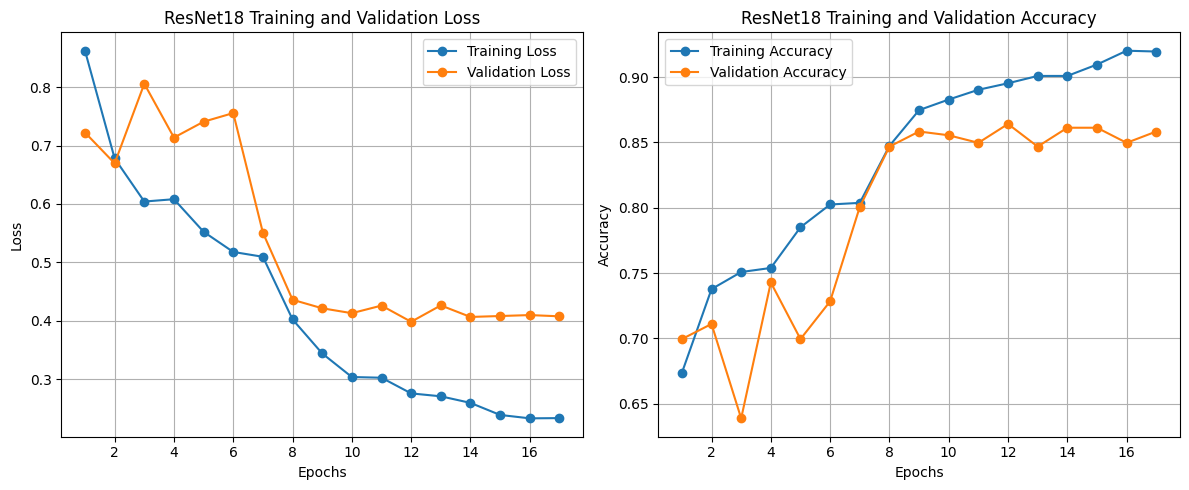


--- Evaluating ResNet18 on Test Set ---
Test Accuracy for ResNet18: 0.8426
Classification Report for ResNet18:
              precision    recall  f1-score   support

         abn       0.95      0.80      0.87       123
         bmt       0.63      0.59      0.61        29
        malg       0.57      0.82      0.67        40
         nml       0.91      0.97      0.94        65
         stn       0.91      0.90      0.90        86

    accuracy                           0.84       343
   macro avg       0.79      0.82      0.80       343
weighted avg       0.86      0.84      0.85       343



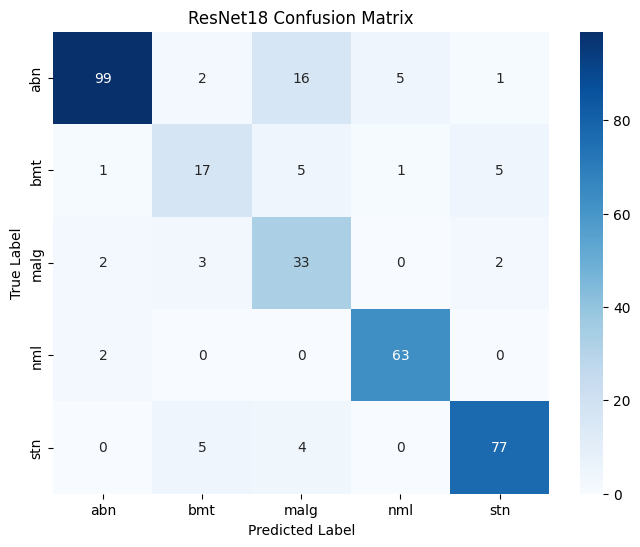

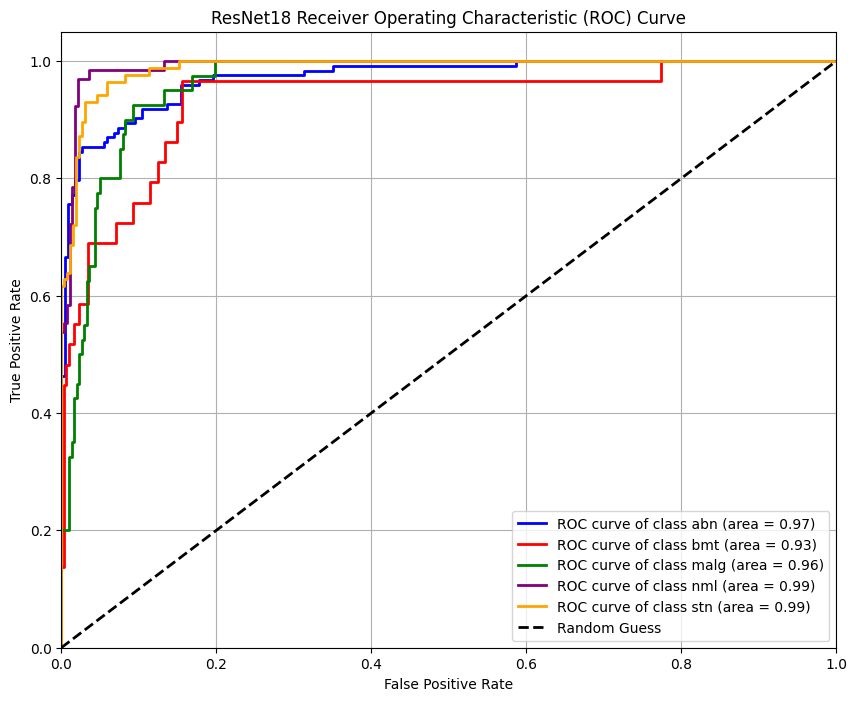

In [30]:
resnet18_model = get_model("resnet18", num_classes=len(class_names))
trained_resnet18_model, train_loss_r18, val_loss_r18, train_acc_r18, val_acc_r18 = train_model(resnet18_model, "ResNet18", epochs=30, patience=5)
plot_accuracy_loss(train_loss_r18, val_loss_r18, train_acc_r18, val_acc_r18, "ResNet18")
y_true_r18, y_pred_classes_r18, y_pred_scores_r18 = evaluate_model_on_test(trained_resnet18_model, "ResNet18")
plot_confusion_matrix(y_true_r18, y_pred_classes_r18, class_names, "ResNet18")
plot_roc_curve(label_binarize(y_true_r18, classes=list(range(NUM_CLASSES))), y_pred_scores_r18, NUM_CLASSES, class_names, "ResNet18")
all_trained_models.append(trained_resnet18_model)

### Efficientnet_B0


--- Training EfficientNetB0 ---
Epoch 0/29
----------
training Loss: 0.8209 Acc: 0.6903
validation Loss: 1.0449 Acc: 0.6850
Epoch 1/29
----------
training Loss: 0.5542 Acc: 0.7807
validation Loss: 0.5240 Acc: 0.8064
Epoch 2/29
----------
training Loss: 0.4821 Acc: 0.8181
validation Loss: 0.5431 Acc: 0.8208
Epoch 3/29
----------
training Loss: 0.4189 Acc: 0.8405
validation Loss: 0.4090 Acc: 0.8324
Epoch 4/29
----------
training Loss: 0.3679 Acc: 0.8667
validation Loss: 0.4408 Acc: 0.8468
Epoch 5/29
----------
training Loss: 0.3825 Acc: 0.8611
validation Loss: 0.3930 Acc: 0.8671
Epoch 6/29
----------
training Loss: 0.2887 Acc: 0.8947
validation Loss: 0.4515 Acc: 0.8382
Epoch 7/29
----------
training Loss: 0.2067 Acc: 0.9277
validation Loss: 0.3821 Acc: 0.8671
Epoch 8/29
----------
training Loss: 0.1688 Acc: 0.9439
validation Loss: 0.3878 Acc: 0.8699
Epoch 9/29
----------
training Loss: 0.1522 Acc: 0.9464
validation Loss: 0.3812 Acc: 0.8699
Epoch 10/29
----------
training Loss: 0.1177 Ac

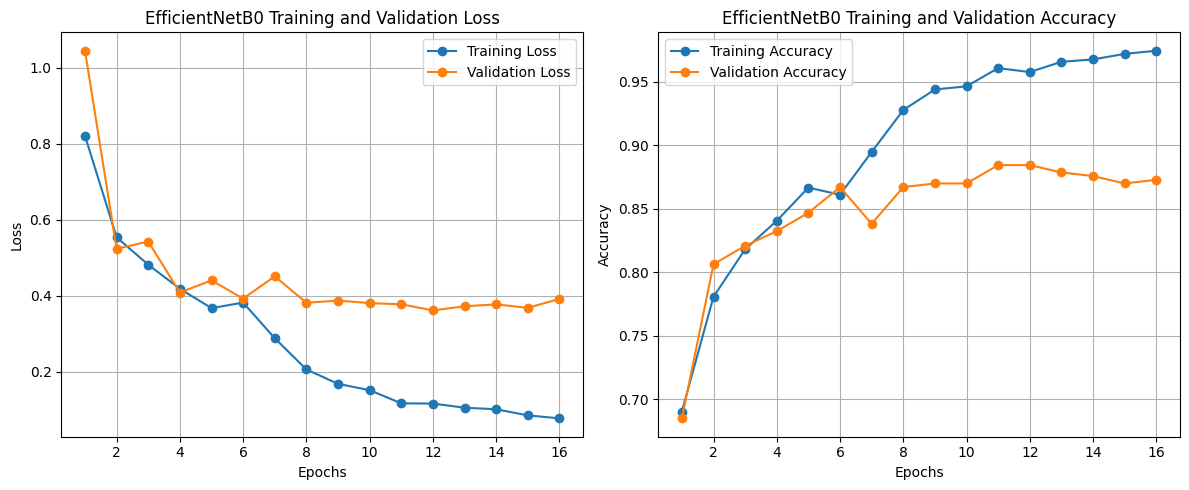


--- Evaluating EfficientNetB0 on Test Set ---
Test Accuracy for EfficientNetB0: 0.8746
Classification Report for EfficientNetB0:
              precision    recall  f1-score   support

         abn       0.92      0.85      0.89       123
         bmt       0.76      0.66      0.70        29
        malg       0.65      0.82      0.73        40
         nml       0.95      0.92      0.94        65
         stn       0.92      0.97      0.94        86

    accuracy                           0.87       343
   macro avg       0.84      0.84      0.84       343
weighted avg       0.88      0.87      0.88       343



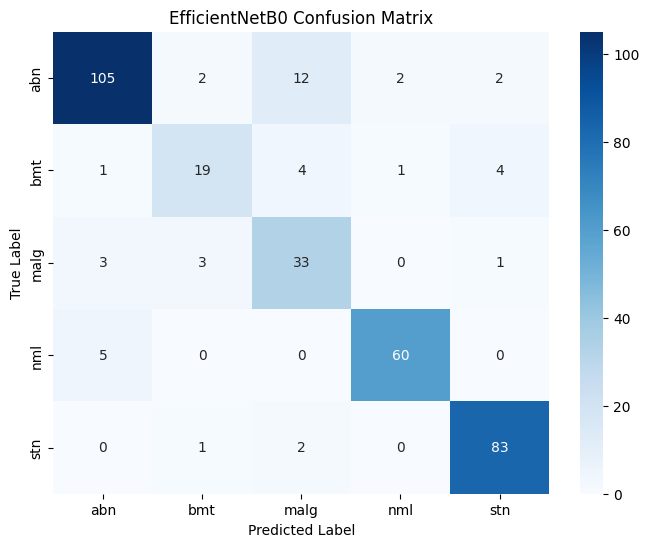

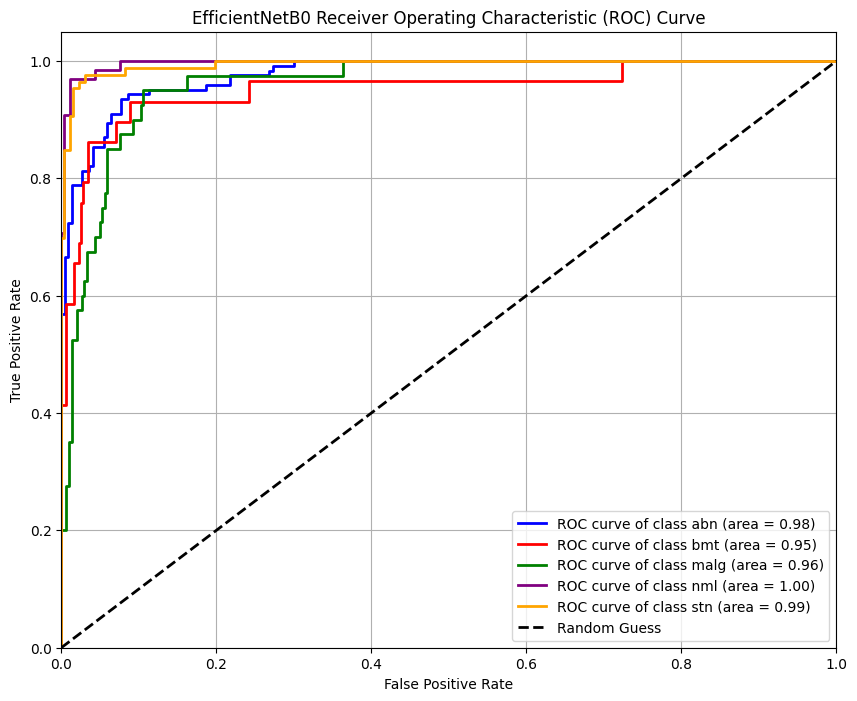

In [31]:
efficientnet_b0_model = get_model("efficientnet_b0", num_classes=len(class_names))
trained_efficientnet_b0_model, train_loss_eb0, val_loss_eb0, train_acc_eb0, val_acc_eb0 = train_model(efficientnet_b0_model, "EfficientNetB0", epochs=30, patience=5)
plot_accuracy_loss(train_loss_eb0, val_loss_eb0, train_acc_eb0, val_acc_eb0, "EfficientNetB0")
y_true_eb0, y_pred_classes_eb0, y_pred_scores_eb0 = evaluate_model_on_test(trained_efficientnet_b0_model, "EfficientNetB0")
plot_confusion_matrix(y_true_eb0, y_pred_classes_eb0, class_names, "EfficientNetB0")
plot_roc_curve(label_binarize(y_true_eb0, classes=list(range(NUM_CLASSES))), y_pred_scores_eb0, NUM_CLASSES, class_names, "EfficientNetB0")
all_trained_models.append(trained_efficientnet_b0_model)

### Densenet-121


--- Training DenseNet121 ---
Epoch 0/29
----------
training Loss: 0.8513 Acc: 0.6773
validation Loss: 1.1392 Acc: 0.6647
Epoch 1/29
----------
training Loss: 0.7073 Acc: 0.7308
validation Loss: 0.7698 Acc: 0.7428
Epoch 2/29
----------
training Loss: 0.6068 Acc: 0.7576
validation Loss: 0.6911 Acc: 0.7457
Epoch 3/29
----------
training Loss: 0.5674 Acc: 0.7801
validation Loss: 0.7749 Acc: 0.7052
Epoch 4/29
----------
training Loss: 0.5155 Acc: 0.8050
validation Loss: 0.5103 Acc: 0.8266
Epoch 5/29
----------
training Loss: 0.5219 Acc: 0.7913
validation Loss: 0.5172 Acc: 0.8035
Epoch 6/29
----------
training Loss: 0.4655 Acc: 0.8237
validation Loss: 0.5287 Acc: 0.8035
Epoch 7/29
----------
training Loss: 0.3538 Acc: 0.8741
validation Loss: 0.4025 Acc: 0.8468
Epoch 8/29
----------
training Loss: 0.3121 Acc: 0.8816
validation Loss: 0.4168 Acc: 0.8526
Epoch 9/29
----------
training Loss: 0.2756 Acc: 0.9022
validation Loss: 0.3937 Acc: 0.8439
Epoch 10/29
----------
training Loss: 0.2742 Acc: 

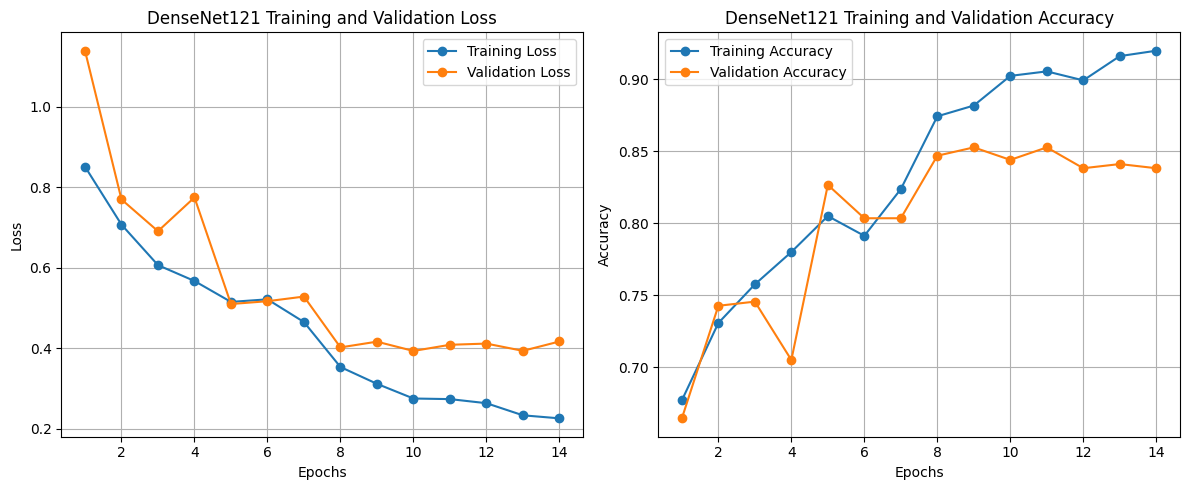


--- Evaluating DenseNet121 on Test Set ---
Test Accuracy for DenseNet121: 0.8426
Classification Report for DenseNet121:
              precision    recall  f1-score   support

         abn       0.89      0.80      0.84       123
         bmt       0.77      0.69      0.73        29
        malg       0.64      0.80      0.71        40
         nml       0.88      0.91      0.89        65
         stn       0.89      0.93      0.91        86

    accuracy                           0.84       343
   macro avg       0.81      0.82      0.82       343
weighted avg       0.85      0.84      0.84       343



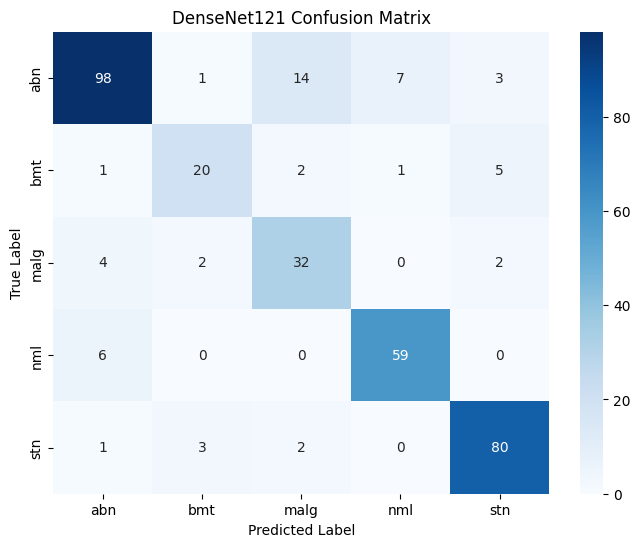

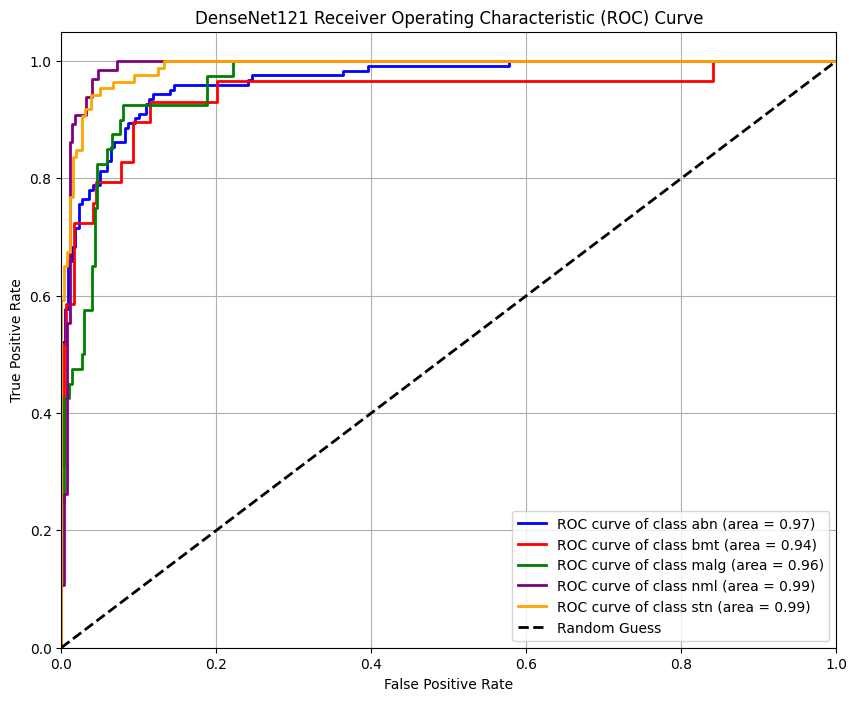

In [32]:
densenet121_model = get_model("densenet121", num_classes=len(class_names))
trained_densenet121_model, train_loss_d121, val_loss_d121, train_acc_d121, val_acc_d121 = train_model(densenet121_model, "DenseNet121", epochs=30, patience=5)
plot_accuracy_loss(train_loss_d121, val_loss_d121, train_acc_d121, val_acc_d121, "DenseNet121")
y_true_d121, y_pred_classes_d121, y_pred_scores_d121 = evaluate_model_on_test(trained_densenet121_model, "DenseNet121")
plot_confusion_matrix(y_true_d121, y_pred_classes_d121, class_names, "DenseNet121")
plot_roc_curve(label_binarize(y_true_d121, classes=list(range(NUM_CLASSES))), y_pred_scores_d121, NUM_CLASSES, class_names, "DenseNet121")
all_trained_models.append(trained_densenet121_model)

### MobileNetV2


--- Training MobileNetV2 ---
Epoch 0/29
----------
training Loss: 0.8882 Acc: 0.6474
validation Loss: 1.0953 Acc: 0.6705
Epoch 1/29
----------
training Loss: 0.7281 Acc: 0.6997
validation Loss: 0.8453 Acc: 0.7572
Epoch 2/29
----------
training Loss: 0.5693 Acc: 0.7925
validation Loss: 0.5436 Acc: 0.7977
Epoch 3/29
----------
training Loss: 0.5697 Acc: 0.7857
validation Loss: 0.5454 Acc: 0.7890
Epoch 4/29
----------
training Loss: 0.5293 Acc: 0.8006
validation Loss: 0.4969 Acc: 0.8150
Epoch 5/29
----------
training Loss: 0.5264 Acc: 0.7888
validation Loss: 0.4894 Acc: 0.7948
Epoch 6/29
----------
training Loss: 0.4685 Acc: 0.8168
validation Loss: 0.5018 Acc: 0.7977
Epoch 7/29
----------
training Loss: 0.3549 Acc: 0.8679
validation Loss: 0.4302 Acc: 0.8468
Epoch 8/29
----------
training Loss: 0.3173 Acc: 0.8829
validation Loss: 0.4063 Acc: 0.8439
Epoch 9/29
----------
training Loss: 0.3015 Acc: 0.8860
validation Loss: 0.4119 Acc: 0.8382
Epoch 10/29
----------
training Loss: 0.2753 Acc: 

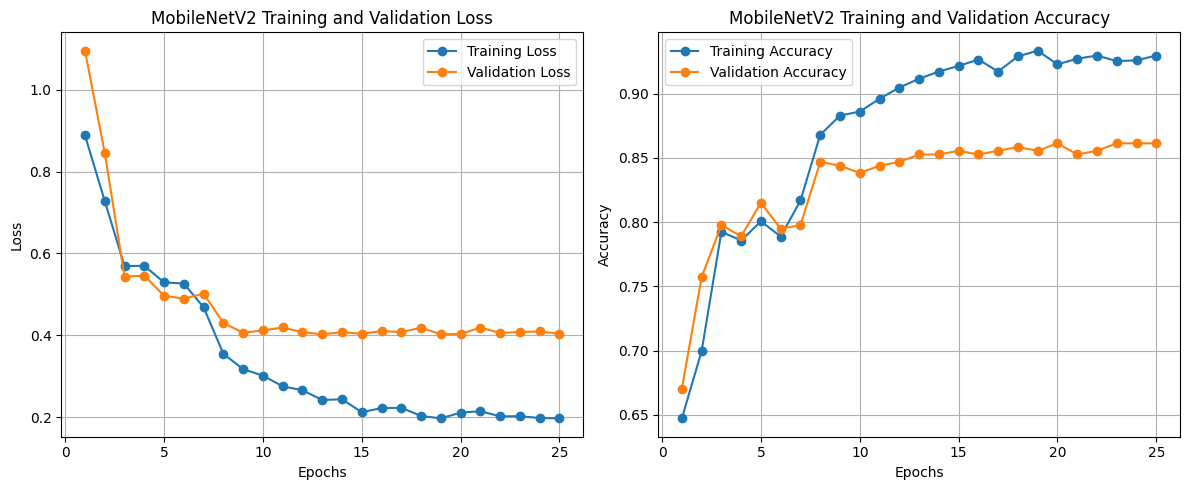


--- Evaluating MobileNetV2 on Test Set ---
Test Accuracy for MobileNetV2: 0.8571
Classification Report for MobileNetV2:
              precision    recall  f1-score   support

         abn       0.93      0.82      0.87       123
         bmt       0.75      0.62      0.68        29
        malg       0.62      0.88      0.73        40
         nml       0.92      0.92      0.92        65
         stn       0.90      0.93      0.91        86

    accuracy                           0.86       343
   macro avg       0.82      0.83      0.82       343
weighted avg       0.87      0.86      0.86       343



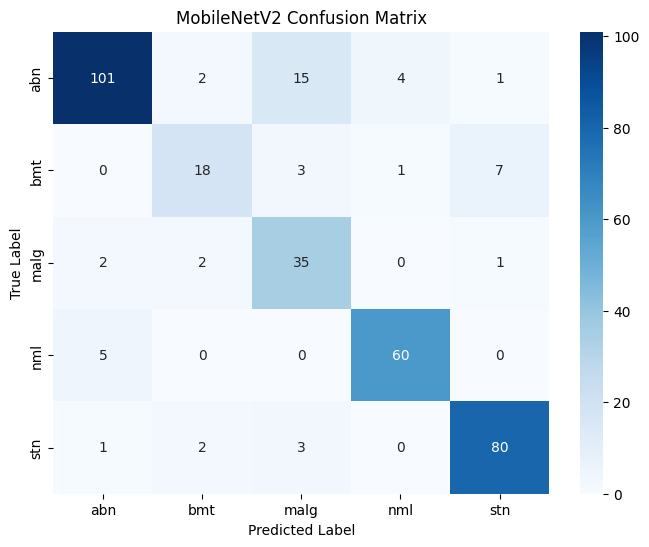

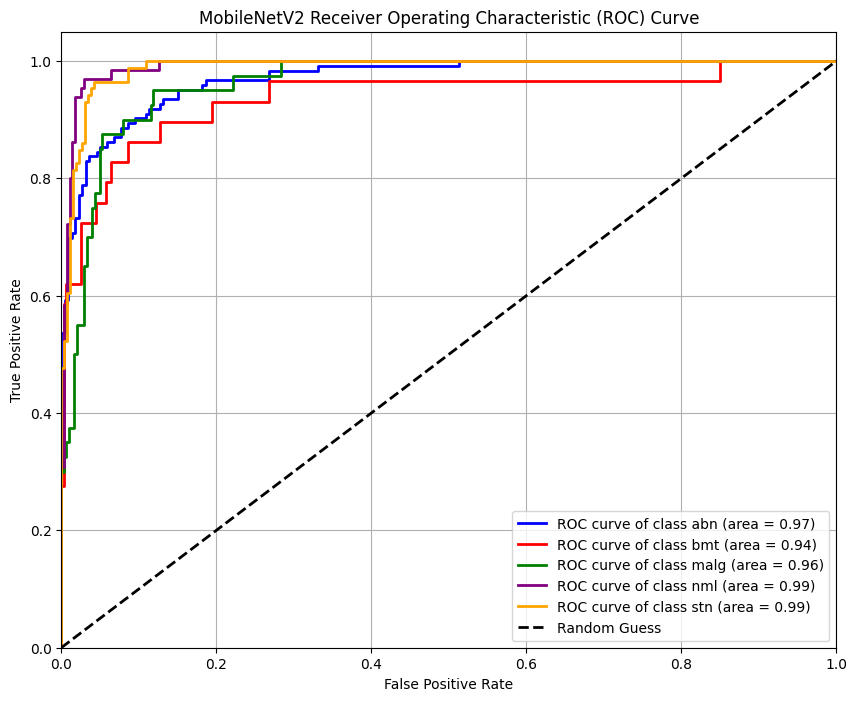

In [33]:
mobilenet_v2_model = get_model("mobilenet_v2", num_classes=len(class_names))
trained_mobilenet_v2_model, train_loss_mv2, val_loss_mv2, train_acc_mv2, val_acc_mv2 = train_model(mobilenet_v2_model, "MobileNetV2", epochs=30, patience=5)
plot_accuracy_loss(train_loss_mv2, val_loss_mv2, train_acc_mv2, val_acc_mv2, "MobileNetV2")
y_true_mv2, y_pred_classes_mv2, y_pred_scores_mv2 = evaluate_model_on_test(trained_mobilenet_v2_model, "MobileNetV2")
plot_confusion_matrix(y_true_mv2, y_pred_classes_mv2, class_names, "MobileNetV2")
plot_roc_curve(label_binarize(y_true_mv2, classes=list(range(NUM_CLASSES))), y_pred_scores_mv2, NUM_CLASSES, class_names, "MobileNetV2")
all_trained_models.append(trained_mobilenet_v2_model)

### ShuffleNetV2


--- Training ShuffleNetV2 ---
Epoch 0/29
----------
training Loss: 1.0793 Acc: 0.6187
validation Loss: 0.6697 Acc: 0.7601
Epoch 1/29
----------
training Loss: 0.6306 Acc: 0.7651
validation Loss: 0.5709 Acc: 0.8035
Epoch 2/29
----------
training Loss: 0.5267 Acc: 0.7963
validation Loss: 0.4803 Acc: 0.8324
Epoch 3/29
----------
training Loss: 0.4476 Acc: 0.8399
validation Loss: 0.4925 Acc: 0.8121
Epoch 4/29
----------
training Loss: 0.4330 Acc: 0.8455
validation Loss: 0.4510 Acc: 0.8150
Epoch 5/29
----------
training Loss: 0.3732 Acc: 0.8723
validation Loss: 0.4524 Acc: 0.8324
Epoch 6/29
----------
training Loss: 0.3585 Acc: 0.8679
validation Loss: 0.4699 Acc: 0.8295
Epoch 7/29
----------
training Loss: 0.2672 Acc: 0.9047
validation Loss: 0.4233 Acc: 0.8468
Epoch 8/29
----------
training Loss: 0.2274 Acc: 0.9227
validation Loss: 0.3784 Acc: 0.8642
Epoch 9/29
----------
training Loss: 0.2165 Acc: 0.9315
validation Loss: 0.3745 Acc: 0.8671
Epoch 10/29
----------
training Loss: 0.2123 Acc:

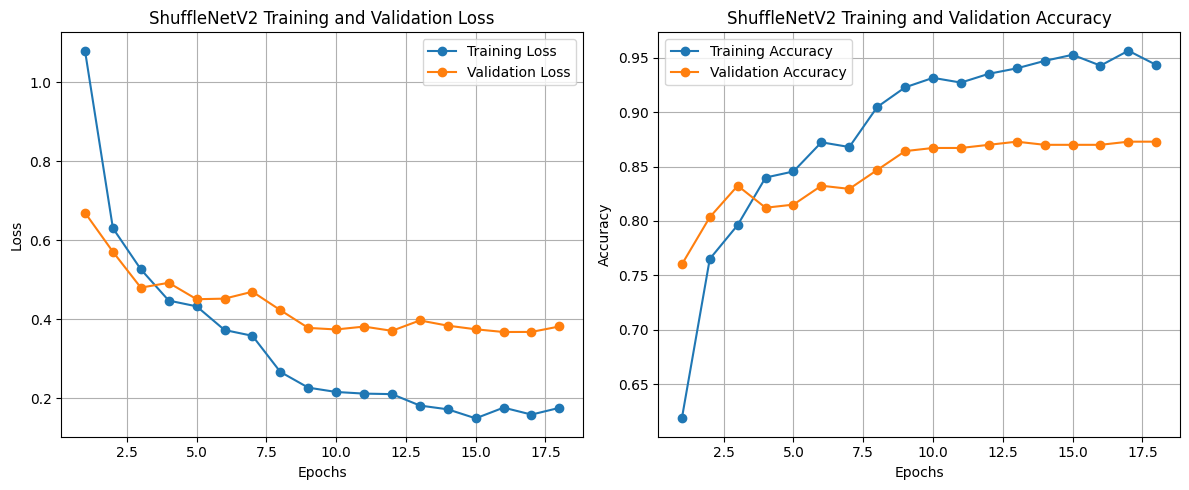


--- Evaluating ShuffleNetV2 on Test Set ---
Test Accuracy for ShuffleNetV2: 0.8513
Classification Report for ShuffleNetV2:
              precision    recall  f1-score   support

         abn       0.88      0.85      0.86       123
         bmt       0.82      0.62      0.71        29
        malg       0.67      0.78      0.72        40
         nml       0.88      0.88      0.88        65
         stn       0.90      0.94      0.92        86

    accuracy                           0.85       343
   macro avg       0.83      0.81      0.82       343
weighted avg       0.85      0.85      0.85       343



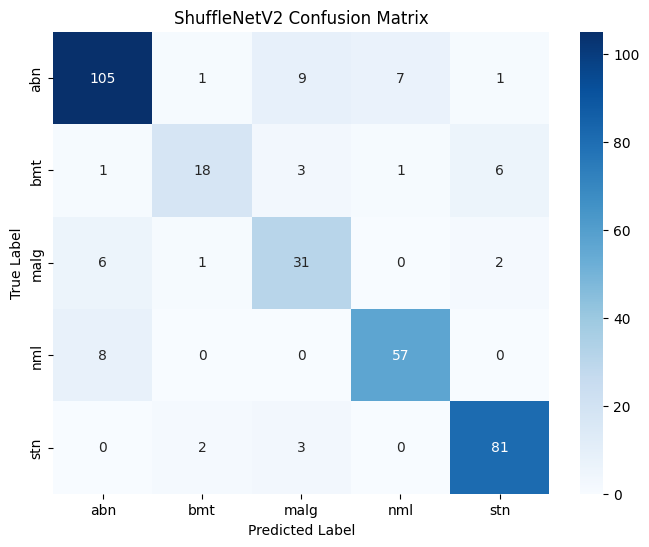

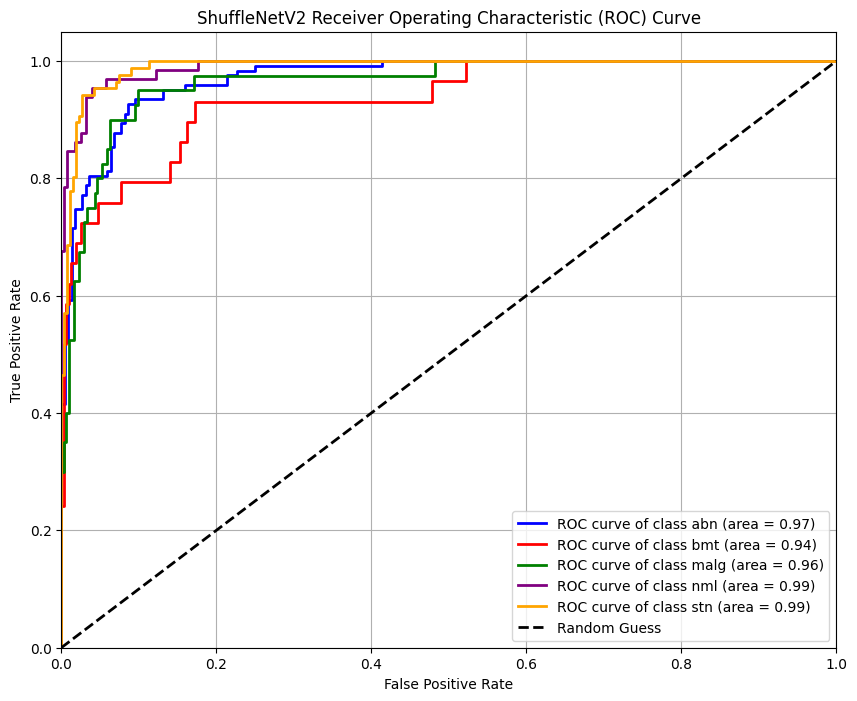

In [34]:
shufflenet_v2_model = get_model("shufflenet_v2", num_classes=len(class_names))
trained_shufflenet_v2_model, train_loss_sv2, val_loss_sv2, train_acc_sv2, val_acc_sv2 = train_model(shufflenet_v2_model, "ShuffleNetV2", epochs=30, patience=5)
plot_accuracy_loss(train_loss_sv2, val_loss_sv2, train_acc_sv2, val_acc_sv2, "ShuffleNetV2")
y_true_sv2, y_pred_classes_sv2, y_pred_scores_sv2 = evaluate_model_on_test(trained_shufflenet_v2_model, "ShuffleNetV2")
plot_confusion_matrix(y_true_sv2, y_pred_classes_sv2, class_names, "ShuffleNetV2")
plot_roc_curve(label_binarize(y_true_sv2, classes=list(range(NUM_CLASSES))), y_pred_scores_sv2, NUM_CLASSES, class_names, "ShuffleNetV2")
all_trained_models.append(trained_shufflenet_v2_model)

### SqueezeNet1_0


--- Training SqueezeNet ---
Epoch 0/29
----------
training Loss: 1.5373 Acc: 0.3894
validation Loss: 1.2384 Acc: 0.5607
Epoch 1/29
----------
training Loss: 1.2121 Acc: 0.5371
validation Loss: 1.2046 Acc: 0.5549
Epoch 2/29
----------
training Loss: 1.1047 Acc: 0.5408
validation Loss: 1.1059 Acc: 0.5809
Epoch 3/29
----------
training Loss: 1.0361 Acc: 0.5844
validation Loss: 1.0200 Acc: 0.5809
Epoch 4/29
----------
training Loss: 0.9838 Acc: 0.5813
validation Loss: 0.9712 Acc: 0.5809
Epoch 5/29
----------
training Loss: 0.9350 Acc: 0.6069
validation Loss: 0.9269 Acc: 0.6127
Epoch 6/29
----------
training Loss: 0.9154 Acc: 0.6137
validation Loss: 1.1705 Acc: 0.5607
Epoch 7/29
----------
training Loss: 0.8875 Acc: 0.6287
validation Loss: 0.8392 Acc: 0.6532
Epoch 8/29
----------
training Loss: 0.8151 Acc: 0.6617
validation Loss: 0.7944 Acc: 0.6618
Epoch 9/29
----------
training Loss: 0.8152 Acc: 0.6467
validation Loss: 0.8080 Acc: 0.6618
Epoch 10/29
----------
training Loss: 0.8081 Acc: 0

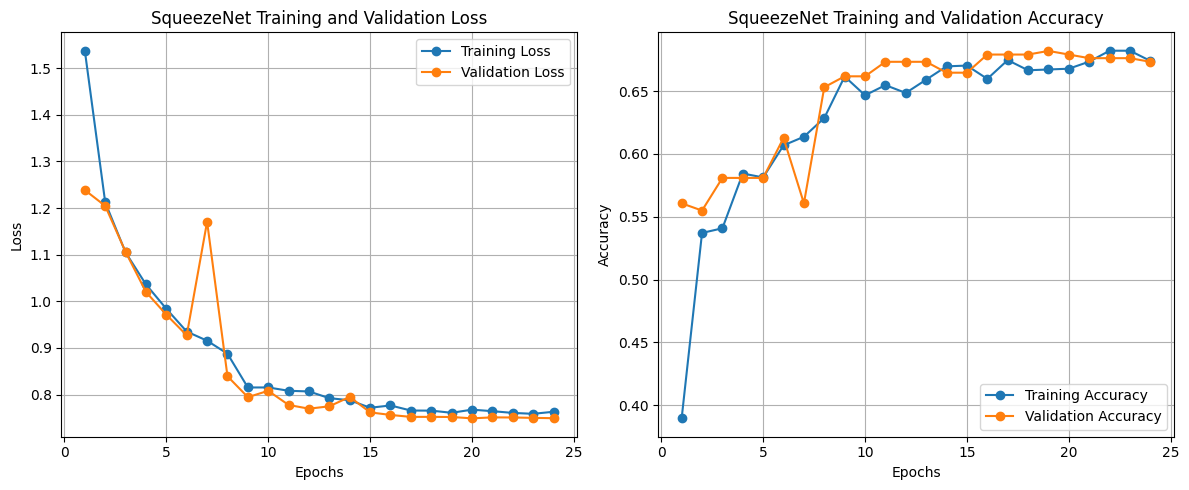


--- Evaluating SqueezeNet on Test Set ---
Test Accuracy for SqueezeNet: 0.7026
Classification Report for SqueezeNet:
              precision    recall  f1-score   support

         abn       0.65      0.88      0.75       123
         bmt       0.73      0.28      0.40        29
        malg       0.82      0.23      0.35        40
         nml       0.73      0.58      0.65        65
         stn       0.75      0.91      0.82        86

    accuracy                           0.70       343
   macro avg       0.74      0.57      0.59       343
weighted avg       0.72      0.70      0.67       343



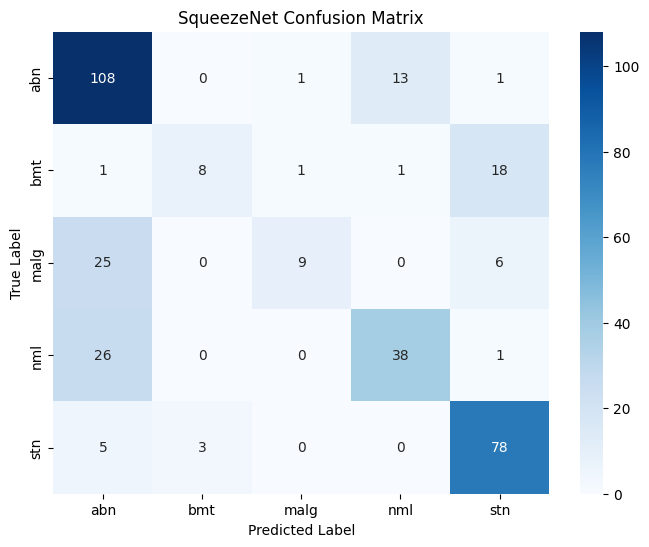

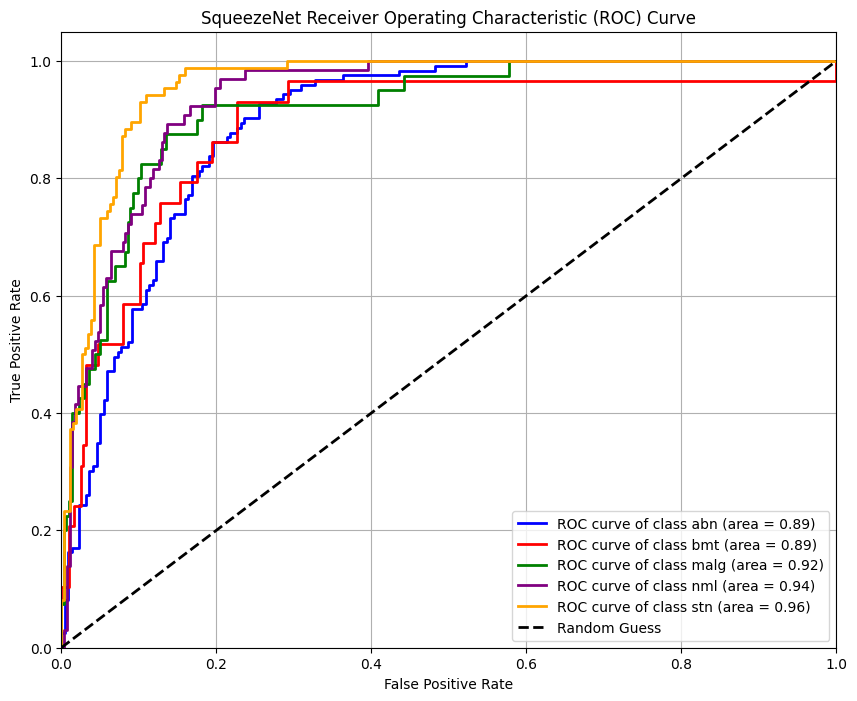

In [35]:
squeezenet_model = get_model("squeezenet", num_classes=len(class_names))
trained_squeezenet_model, train_loss_sqz, val_loss_sqz, train_acc_sqz, val_acc_sqz = train_model(squeezenet_model, "SqueezeNet", epochs=30, patience=5)
plot_accuracy_loss(train_loss_sqz, val_loss_sqz, train_acc_sqz, val_acc_sqz, "SqueezeNet")
y_true_sqz, y_pred_classes_sqz, y_pred_scores_sqz = evaluate_model_on_test(trained_squeezenet_model, "SqueezeNet")
plot_confusion_matrix(y_true_sqz, y_pred_classes_sqz, class_names, "SqueezeNet")
plot_roc_curve(label_binarize(y_true_sqz, classes=list(range(NUM_CLASSES))), y_pred_scores_sqz, NUM_CLASSES, class_names, "SqueezeNet")
all_trained_models.append(trained_squeezenet_model)

### Densenet201


--- Training DenseNet201 ---
Epoch 0/29
----------
training Loss: 0.9296 Acc: 0.6343
validation Loss: 1.5466 Acc: 0.5780
Epoch 1/29
----------
training Loss: 0.7296 Acc: 0.7090
validation Loss: 0.7700 Acc: 0.7168
Epoch 2/29
----------
training Loss: 0.6509 Acc: 0.7427
validation Loss: 0.6741 Acc: 0.7399
Epoch 3/29
----------
training Loss: 0.6004 Acc: 0.7445
validation Loss: 0.7158 Acc: 0.7168
Epoch 4/29
----------
training Loss: 0.6131 Acc: 0.7664
validation Loss: 0.5260 Acc: 0.7890
Epoch 5/29
----------
training Loss: 0.5068 Acc: 0.8062
validation Loss: 1.3719 Acc: 0.6705
Epoch 6/29
----------
training Loss: 0.5133 Acc: 0.8075
validation Loss: 0.5782 Acc: 0.7861
Epoch 7/29
----------
training Loss: 0.3971 Acc: 0.8517
validation Loss: 0.4209 Acc: 0.8439
Epoch 8/29
----------
training Loss: 0.3569 Acc: 0.8673
validation Loss: 0.4070 Acc: 0.8555
Epoch 9/29
----------
training Loss: 0.3323 Acc: 0.8879
validation Loss: 0.3771 Acc: 0.8757
Epoch 10/29
----------
training Loss: 0.3157 Acc: 

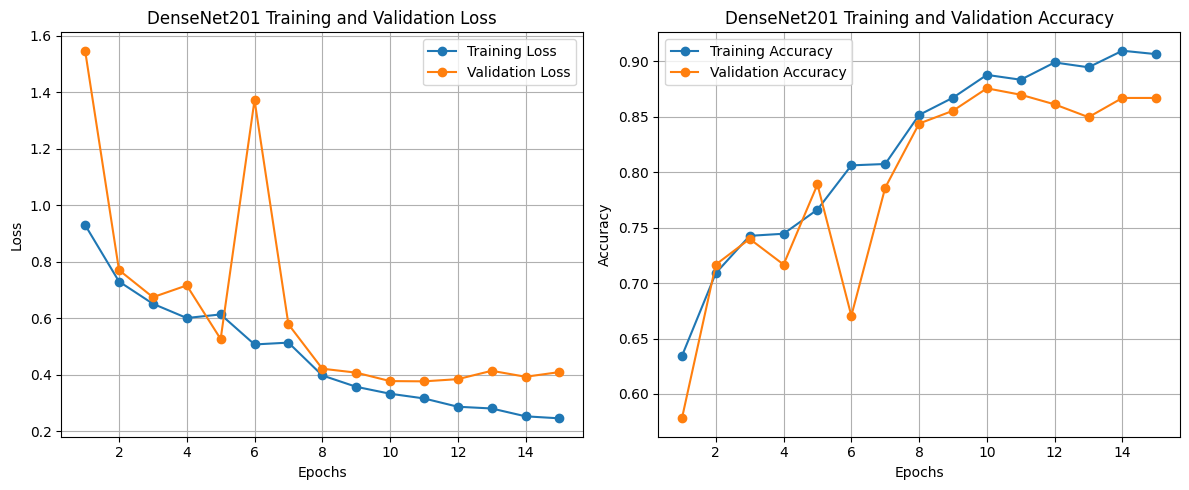


--- Evaluating DenseNet201 on Test Set ---
Test Accuracy for DenseNet201: 0.8513
Classification Report for DenseNet201:
              precision    recall  f1-score   support

         abn       0.92      0.80      0.86       123
         bmt       0.70      0.72      0.71        29
        malg       0.65      0.82      0.73        40
         nml       0.88      0.92      0.90        65
         stn       0.92      0.92      0.92        86

    accuracy                           0.85       343
   macro avg       0.81      0.84      0.82       343
weighted avg       0.86      0.85      0.85       343



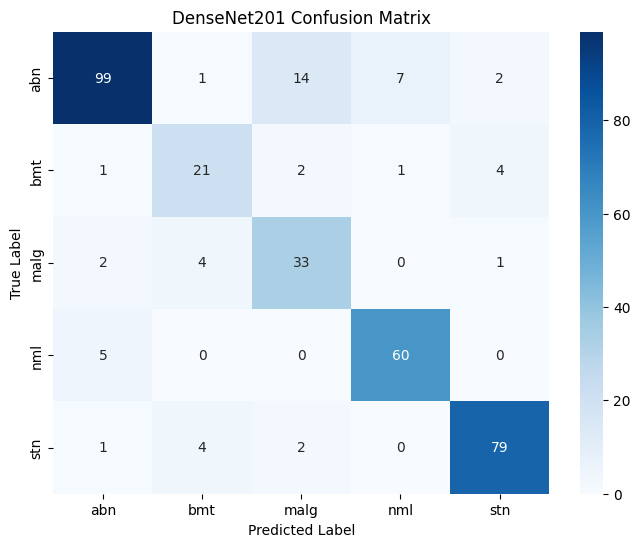

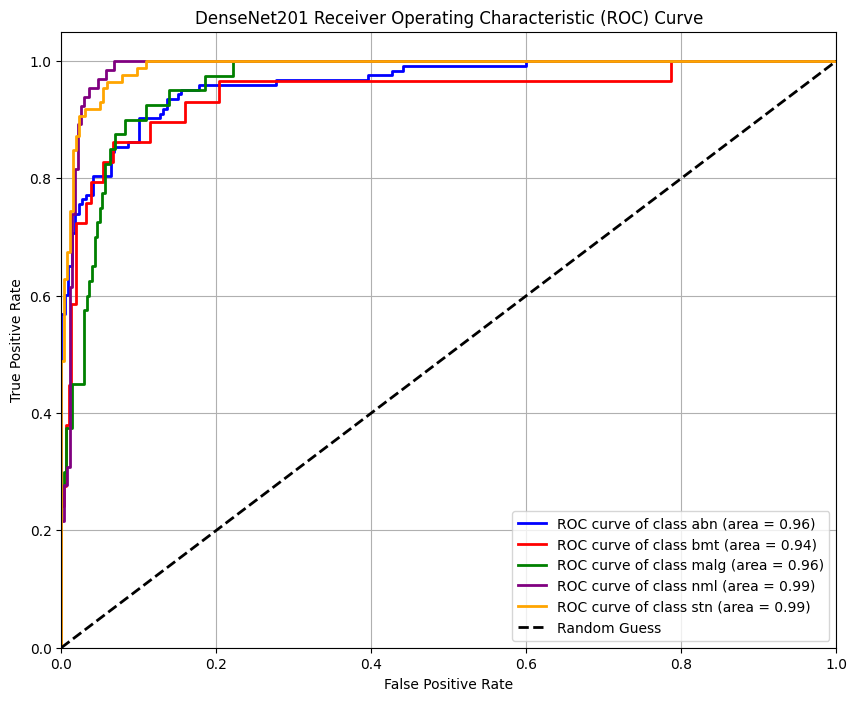

In [36]:
densenet201_model = get_model("densenet201", num_classes=len(class_names))
trained_densenet201_model, train_loss_d201, val_loss_d201, train_acc_d201, val_acc_d201 = train_model(densenet201_model, "DenseNet201", epochs=30, patience=5)
plot_accuracy_loss(train_loss_d201, val_loss_d201, train_acc_d201, val_acc_d201, "DenseNet201")
y_true_d201, y_pred_classes_d201, y_pred_scores_d201 = evaluate_model_on_test(trained_densenet201_model, "DenseNet201")
plot_confusion_matrix(y_true_d201, y_pred_classes_d201, class_names, "DenseNet201")
plot_roc_curve(label_binarize(y_true_d201, classes=list(range(NUM_CLASSES))), y_pred_scores_d201, NUM_CLASSES, class_names, "DenseNet201")
all_trained_models.append(trained_densenet201_model)

### EfficientNet-B1


--- Training EfficientNetB1 ---
Epoch 0/29
----------
training Loss: 0.8053 Acc: 0.7047
validation Loss: 0.7201 Acc: 0.7457
Epoch 1/29
----------
training Loss: 0.5503 Acc: 0.7956
validation Loss: 0.6688 Acc: 0.7803
Epoch 2/29
----------
training Loss: 0.4371 Acc: 0.8349
validation Loss: 0.4016 Acc: 0.8439
Epoch 3/29
----------
training Loss: 0.3878 Acc: 0.8555
validation Loss: 0.4422 Acc: 0.8497
Epoch 4/29
----------
training Loss: 0.3559 Acc: 0.8766
validation Loss: 0.6840 Acc: 0.7832
Epoch 5/29
----------
training Loss: 0.3459 Acc: 0.8773
validation Loss: 0.4933 Acc: 0.8295
Epoch 6/29
----------
training Loss: 0.3021 Acc: 0.8928
validation Loss: 0.4719 Acc: 0.8266
Epoch 7/29
----------
training Loss: 0.1843 Acc: 0.9315
validation Loss: 0.3833 Acc: 0.8728
Epoch 8/29
----------
training Loss: 0.1486 Acc: 0.9452
validation Loss: 0.4022 Acc: 0.8584
Epoch 9/29
----------
training Loss: 0.1115 Acc: 0.9626
validation Loss: 0.3910 Acc: 0.8584
Epoch 10/29
----------
training Loss: 0.1027 Ac

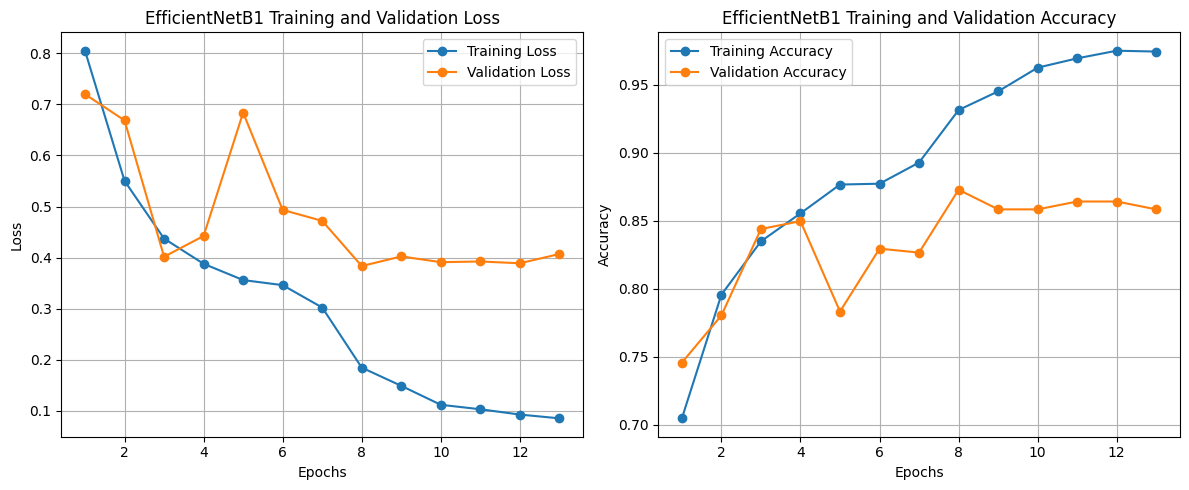


--- Evaluating EfficientNetB1 on Test Set ---
Test Accuracy for EfficientNetB1: 0.8776
Classification Report for EfficientNetB1:
              precision    recall  f1-score   support

         abn       0.90      0.87      0.88       123
         bmt       0.86      0.66      0.75        29
        malg       0.66      0.82      0.73        40
         nml       0.94      0.94      0.94        65
         stn       0.93      0.94      0.94        86

    accuracy                           0.88       343
   macro avg       0.86      0.85      0.85       343
weighted avg       0.88      0.88      0.88       343



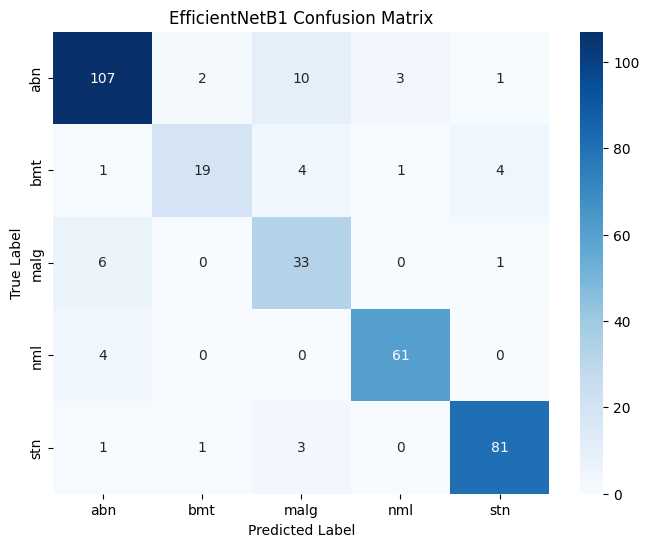

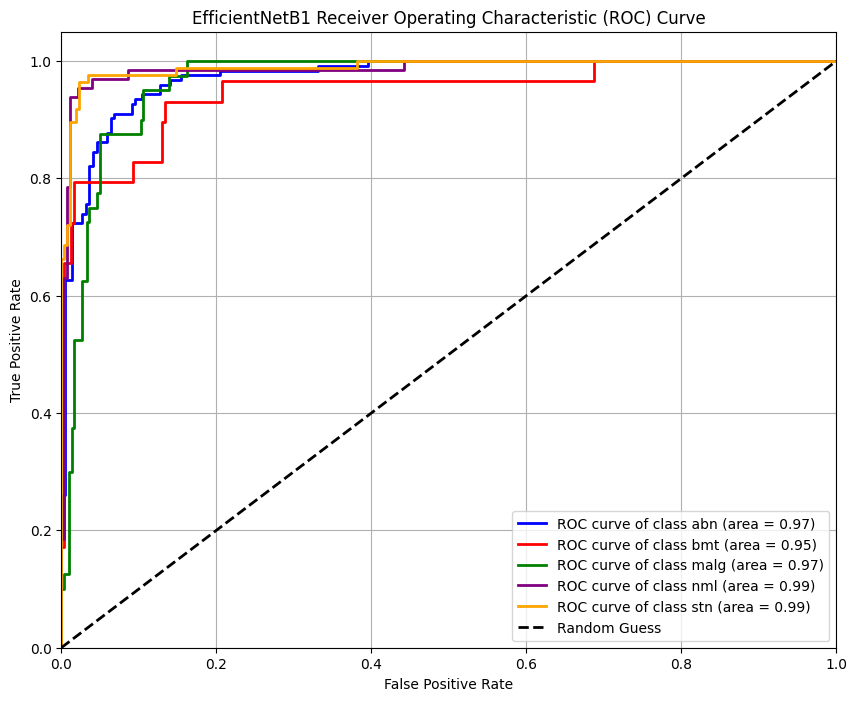

In [37]:
efficientnet_b1_model = get_model("efficientnet_b1", num_classes=len(class_names))
trained_efficientnet_b1_model, train_loss_eb1, val_loss_eb1, train_acc_eb1, val_acc_eb1 = train_model(efficientnet_b1_model, "EfficientNetB1", epochs=30, patience=5)
plot_accuracy_loss(train_loss_eb1, val_loss_eb1, train_acc_eb1, val_acc_eb1, "EfficientNetB1")
y_true_eb1, y_pred_classes_eb1, y_pred_scores_eb1 = evaluate_model_on_test(trained_efficientnet_b1_model, "EfficientNetB1")
plot_confusion_matrix(y_true_eb1, y_pred_classes_eb1, class_names, "EfficientNetB1")
plot_roc_curve(label_binarize(y_true_eb1, classes=list(range(NUM_CLASSES))), y_pred_scores_eb1, NUM_CLASSES, class_names, "EfficientNetB1")
all_trained_models.append(trained_efficientnet_b1_model)

### EfficientNet-B2


--- Training EfficientNetB2 ---
Epoch 0/29
----------
training Loss: 0.8259 Acc: 0.6885
validation Loss: 1.3212 Acc: 0.6879
Epoch 1/29
----------
training Loss: 0.6182 Acc: 0.7738
validation Loss: 0.5665 Acc: 0.8237
Epoch 2/29
----------
training Loss: 0.4635 Acc: 0.8324
validation Loss: 0.5089 Acc: 0.8092
Epoch 3/29
----------
training Loss: 0.4483 Acc: 0.8424
validation Loss: 0.4689 Acc: 0.8179
Epoch 4/29
----------
training Loss: 0.3856 Acc: 0.8629
validation Loss: 0.4377 Acc: 0.8468
Epoch 5/29
----------
training Loss: 0.3029 Acc: 0.8916
validation Loss: 0.4695 Acc: 0.8266
Epoch 6/29
----------
training Loss: 0.3243 Acc: 0.8903
validation Loss: 0.3912 Acc: 0.8497
Epoch 7/29
----------
training Loss: 0.1877 Acc: 0.9277
validation Loss: 0.3311 Acc: 0.8757
Epoch 8/29
----------
training Loss: 0.1408 Acc: 0.9520
validation Loss: 0.3619 Acc: 0.8786
Epoch 9/29
----------
training Loss: 0.1180 Acc: 0.9576
validation Loss: 0.3269 Acc: 0.8757
Epoch 10/29
----------
training Loss: 0.0897 Ac

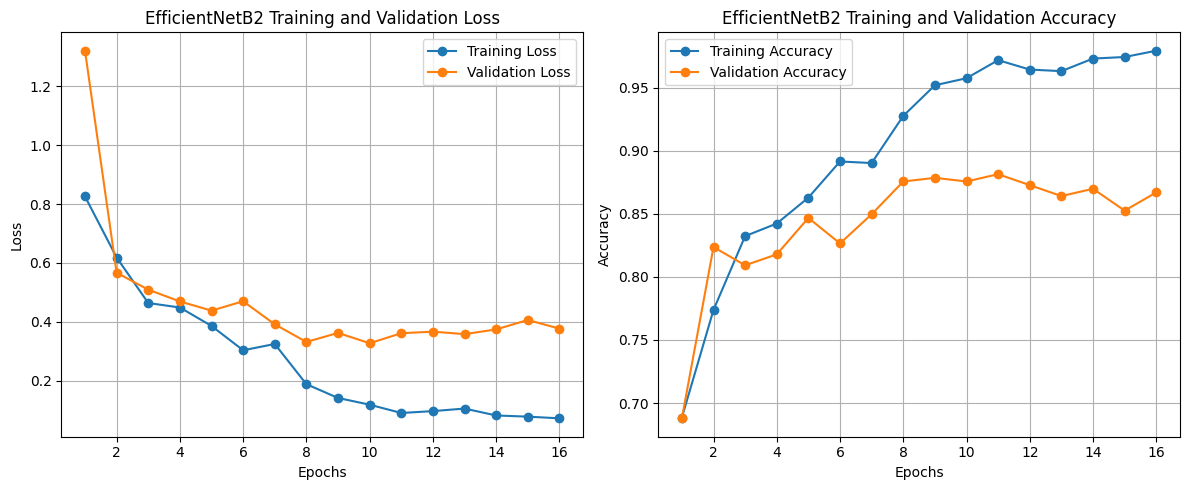


--- Evaluating EfficientNetB2 on Test Set ---
Test Accuracy for EfficientNetB2: 0.8863
Classification Report for EfficientNetB2:
              precision    recall  f1-score   support

         abn       0.94      0.87      0.90       123
         bmt       0.79      0.66      0.72        29
        malg       0.65      0.85      0.74        40
         nml       0.97      0.94      0.95        65
         stn       0.92      0.97      0.94        86

    accuracy                           0.89       343
   macro avg       0.85      0.86      0.85       343
weighted avg       0.89      0.89      0.89       343



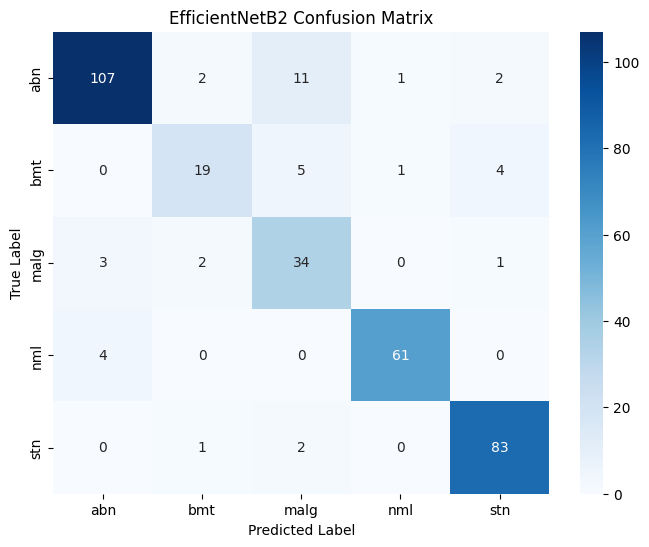

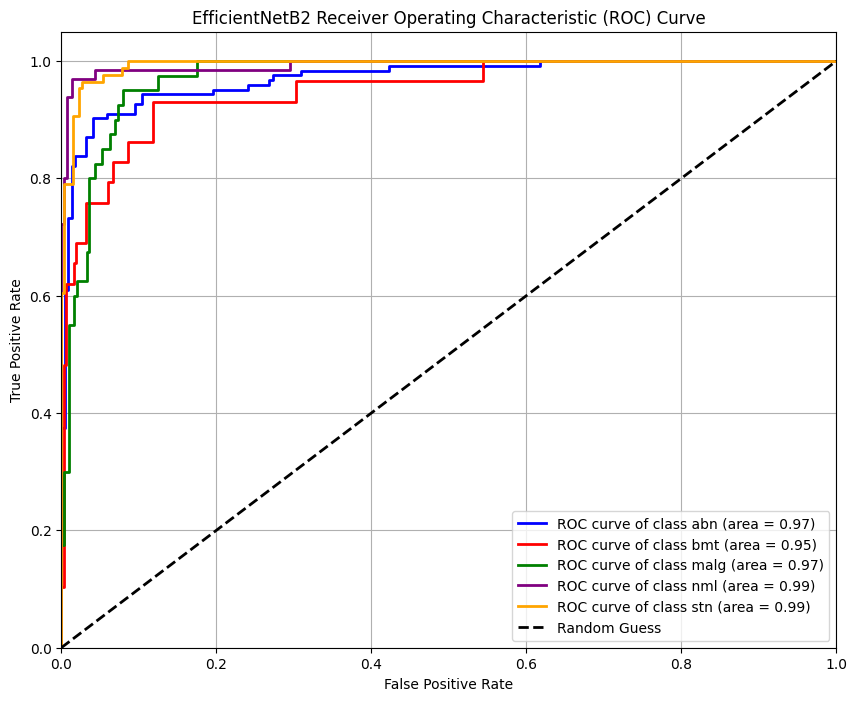

In [38]:
efficientnet_b2_model = get_model("efficientnet_b2", num_classes=len(class_names))
trained_efficientnet_b2_model, train_loss_eb2, val_loss_eb2, train_acc_eb2, val_acc_eb2 = train_model(efficientnet_b2_model, "EfficientNetB2", epochs=30, patience=5)
plot_accuracy_loss(train_loss_eb2, val_loss_eb2, train_acc_eb2, val_acc_eb2, "EfficientNetB2")
y_true_eb2, y_pred_classes_eb2, y_pred_scores_eb2 = evaluate_model_on_test(trained_efficientnet_b2_model, "EfficientNetB2")
plot_confusion_matrix(y_true_eb2, y_pred_classes_eb2, class_names, "EfficientNetB2")
plot_roc_curve(label_binarize(y_true_eb2, classes=list(range(NUM_CLASSES))), y_pred_scores_eb2, NUM_CLASSES, class_names, "EfficientNetB2")
all_trained_models.append(trained_efficientnet_b2_model)

### EfficientNet-B3


--- Training EfficientNetB3 ---
Epoch 0/29
----------
training Loss: 0.8257 Acc: 0.6897
validation Loss: 0.6132 Acc: 0.7861
Epoch 1/29
----------
training Loss: 0.6109 Acc: 0.7745
validation Loss: 0.5236 Acc: 0.8035
Epoch 2/29
----------
training Loss: 0.4618 Acc: 0.8231
validation Loss: 0.4345 Acc: 0.8237
Epoch 3/29
----------
training Loss: 0.4134 Acc: 0.8411
validation Loss: 0.4931 Acc: 0.8353
Epoch 4/29
----------
training Loss: 0.3871 Acc: 0.8654
validation Loss: 0.4527 Acc: 0.8324
Epoch 5/29
----------
training Loss: 0.3112 Acc: 0.8847
validation Loss: 0.4173 Acc: 0.8497
Epoch 6/29
----------
training Loss: 0.2627 Acc: 0.9047
validation Loss: 0.5291 Acc: 0.8382
Epoch 7/29
----------
training Loss: 0.2209 Acc: 0.9209
validation Loss: 0.3842 Acc: 0.8497
Epoch 8/29
----------
training Loss: 0.1454 Acc: 0.9502
validation Loss: 0.3801 Acc: 0.8613
Epoch 9/29
----------
training Loss: 0.1252 Acc: 0.9558
validation Loss: 0.4014 Acc: 0.8699
Epoch 10/29
----------
training Loss: 0.1096 Ac

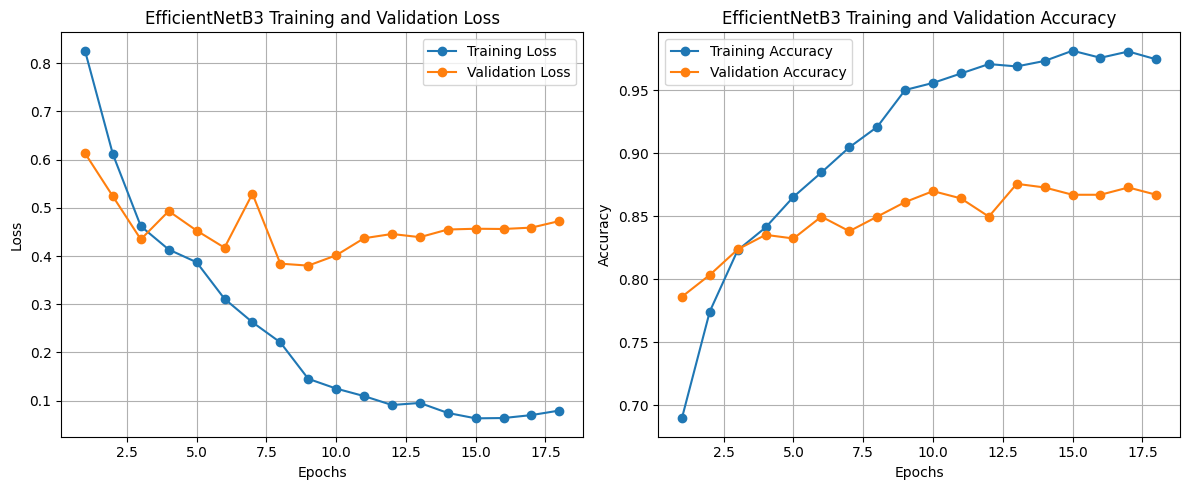


--- Evaluating EfficientNetB3 on Test Set ---
Test Accuracy for EfficientNetB3: 0.8776
Classification Report for EfficientNetB3:
              precision    recall  f1-score   support

         abn       0.91      0.86      0.89       123
         bmt       0.81      0.59      0.68        29
        malg       0.68      0.80      0.74        40
         nml       0.95      0.95      0.95        65
         stn       0.89      0.98      0.93        86

    accuracy                           0.88       343
   macro avg       0.85      0.84      0.84       343
weighted avg       0.88      0.88      0.88       343



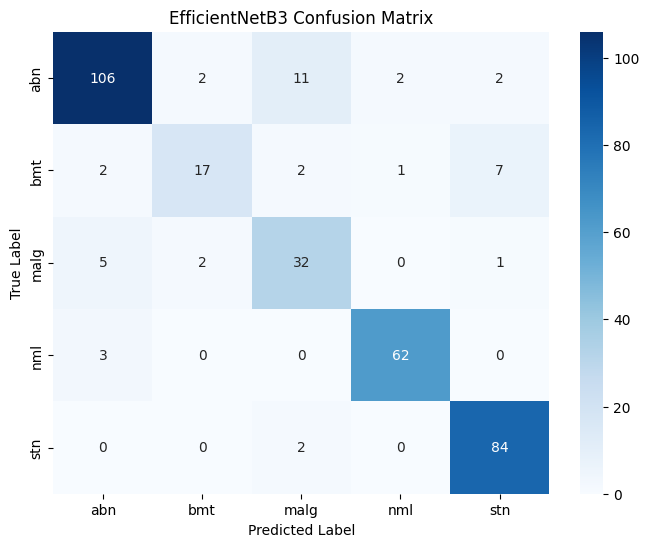

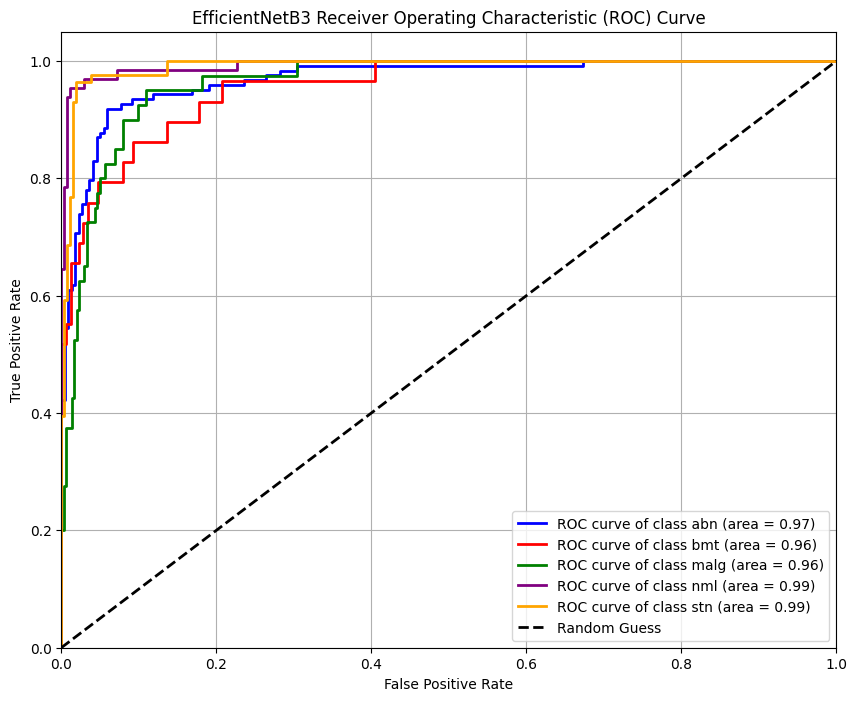

In [39]:
efficientnet_b3_model = get_model("efficientnet_b3", num_classes=len(class_names))
trained_efficientnet_b3_model, train_loss_eb3, val_loss_eb3, train_acc_eb3, val_acc_eb3 = train_model(efficientnet_b3_model, "EfficientNetB3", epochs=30, patience=5)
plot_accuracy_loss(train_loss_eb3, val_loss_eb3, train_acc_eb3, val_acc_eb3, "EfficientNetB3")
y_true_eb3, y_pred_classes_eb3, y_pred_scores_eb3 = evaluate_model_on_test(trained_efficientnet_b3_model, "EfficientNetB3")
plot_confusion_matrix(y_true_eb3, y_pred_classes_eb3, class_names, "EfficientNetB3")
plot_roc_curve(label_binarize(y_true_eb3, classes=list(range(NUM_CLASSES))), y_pred_scores_eb3, NUM_CLASSES, class_names, "EfficientNetB3")
all_trained_models.append(trained_efficientnet_b3_model)

### EfficientNet-B4


--- Training EfficientNetB4 ---
Epoch 0/29
----------
training Loss: 0.9197 Acc: 0.6548
validation Loss: 0.5864 Acc: 0.7977
Epoch 1/29
----------
training Loss: 0.5357 Acc: 0.8031
validation Loss: 0.4702 Acc: 0.8324
Epoch 2/29
----------
training Loss: 0.3916 Acc: 0.8455
validation Loss: 0.4395 Acc: 0.8150
Epoch 3/29
----------
training Loss: 0.3538 Acc: 0.8623
validation Loss: 0.5681 Acc: 0.8006
Epoch 4/29
----------
training Loss: 0.2972 Acc: 0.8916
validation Loss: 0.5014 Acc: 0.8179
Epoch 5/29
----------
training Loss: 0.2151 Acc: 0.9178
validation Loss: 0.5893 Acc: 0.8266
Epoch 6/29
----------
training Loss: 0.1816 Acc: 0.9371
validation Loss: 0.4856 Acc: 0.8497
Epoch 7/29
----------
training Loss: 0.1411 Acc: 0.9477
validation Loss: 0.4409 Acc: 0.8555
Epoch 8/29
----------
training Loss: 0.1041 Acc: 0.9657
validation Loss: 0.4552 Acc: 0.8699
Epoch 9/29
----------
training Loss: 0.1072 Acc: 0.9651
validation Loss: 0.4785 Acc: 0.8526
Epoch 10/29
----------
training Loss: 0.0901 Ac

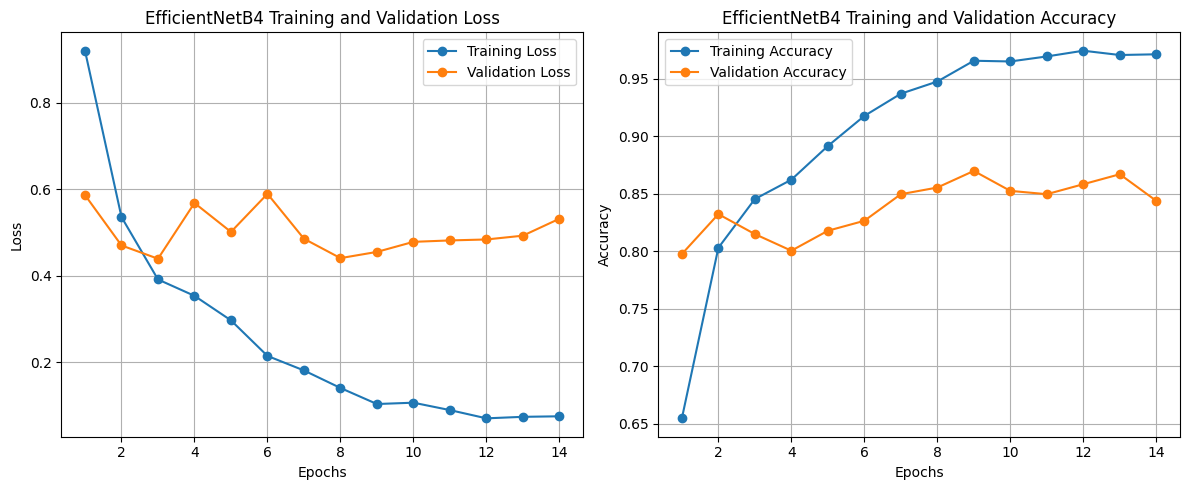


--- Evaluating EfficientNetB4 on Test Set ---
Test Accuracy for EfficientNetB4: 0.8659
Classification Report for EfficientNetB4:
              precision    recall  f1-score   support

         abn       0.88      0.87      0.87       123
         bmt       0.75      0.72      0.74        29
        malg       0.67      0.78      0.72        40
         nml       0.95      0.91      0.93        65
         stn       0.93      0.92      0.92        86

    accuracy                           0.87       343
   macro avg       0.84      0.84      0.84       343
weighted avg       0.87      0.87      0.87       343



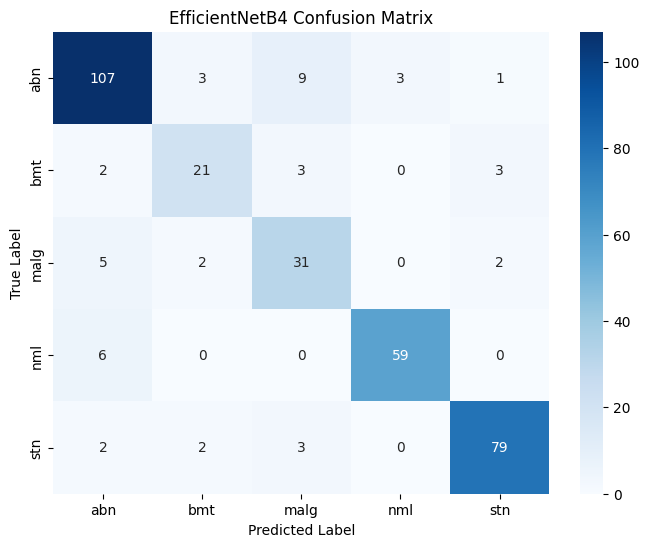

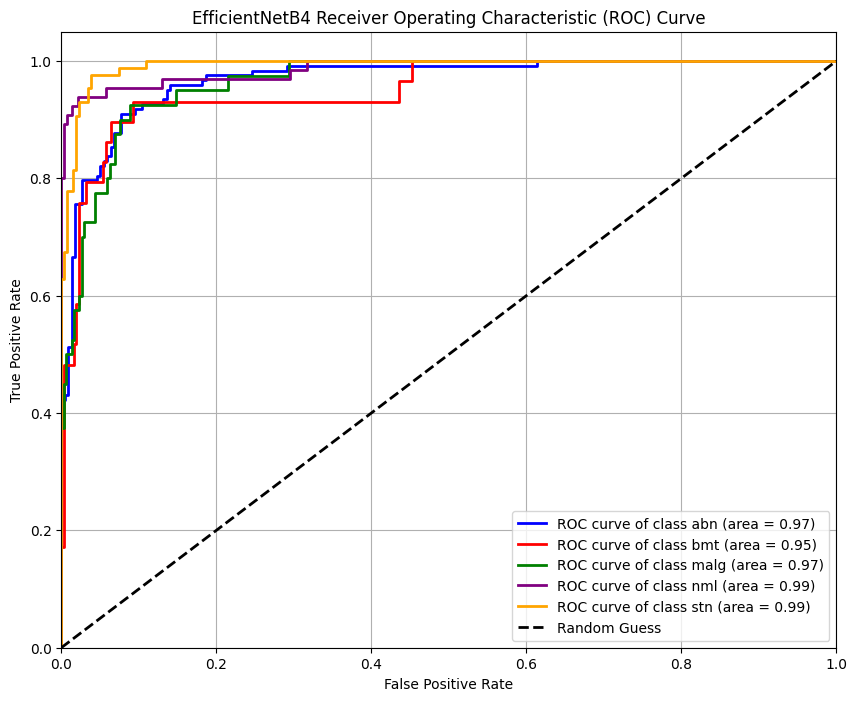

In [40]:
efficientnet_b4_model = get_model("efficientnet_b4", num_classes=len(class_names))
trained_efficientnet_b4_model, train_loss_eb4, val_loss_eb4, train_acc_eb4, val_acc_eb4 = train_model(efficientnet_b4_model, "EfficientNetB4", epochs=30, patience=5)
plot_accuracy_loss(train_loss_eb4, val_loss_eb4, train_acc_eb4, val_acc_eb4, "EfficientNetB4")
y_true_eb4, y_pred_classes_eb4, y_pred_scores_eb4 = evaluate_model_on_test(trained_efficientnet_b4_model, "EfficientNetB4")
plot_confusion_matrix(y_true_eb4, y_pred_classes_eb4, class_names, "EfficientNetB4")
plot_roc_curve(label_binarize(y_true_eb4, classes=list(range(NUM_CLASSES))), y_pred_scores_eb4, NUM_CLASSES, class_names, "EfficientNetB4")
all_trained_models.append(trained_efficientnet_b4_model)

### ResNet-50 V1


--- Training ResNet50V1 ---
Epoch 0/29
----------
training Loss: 1.0844 Acc: 0.5776
validation Loss: 1.5935 Acc: 0.5376
Epoch 1/29
----------
training Loss: 0.8665 Acc: 0.6461
validation Loss: 0.7810 Acc: 0.6676
Epoch 2/29
----------
training Loss: 0.8147 Acc: 0.6685
validation Loss: 0.9492 Acc: 0.6561
Epoch 3/29
----------
training Loss: 0.6730 Acc: 0.7427
validation Loss: 0.7816 Acc: 0.7283
Epoch 4/29
----------
training Loss: 0.6754 Acc: 0.7389
validation Loss: 0.8720 Acc: 0.6705
Epoch 5/29
----------
training Loss: 0.6476 Acc: 0.7364
validation Loss: 0.5599 Acc: 0.7601
Epoch 6/29
----------
training Loss: 0.6159 Acc: 0.7558
validation Loss: 0.5674 Acc: 0.7717
Epoch 7/29
----------
training Loss: 0.4862 Acc: 0.8162
validation Loss: 0.4578 Acc: 0.8266
Epoch 8/29
----------
training Loss: 0.4706 Acc: 0.8274
validation Loss: 0.4554 Acc: 0.8382
Epoch 9/29
----------
training Loss: 0.4228 Acc: 0.8287
validation Loss: 0.4453 Acc: 0.8208
Epoch 10/29
----------
training Loss: 0.4375 Acc: 0

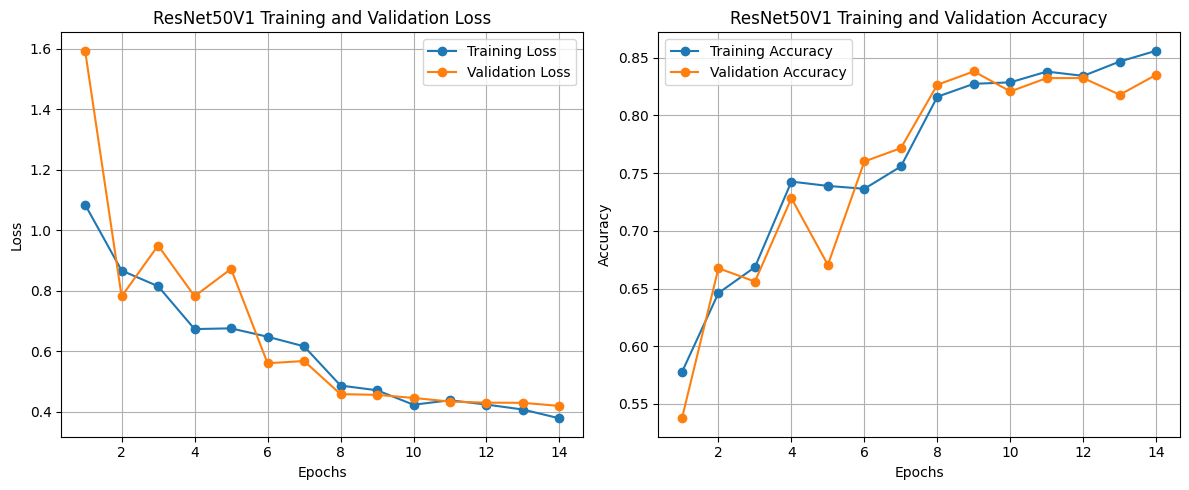


--- Evaluating ResNet50V1 on Test Set ---
Test Accuracy for ResNet50V1: 0.8338
Classification Report for ResNet50V1:
              precision    recall  f1-score   support

         abn       0.92      0.80      0.85       123
         bmt       0.68      0.52      0.59        29
        malg       0.61      0.93      0.73        40
         nml       0.92      0.89      0.91        65
         stn       0.87      0.91      0.89        86

    accuracy                           0.83       343
   macro avg       0.80      0.81      0.79       343
weighted avg       0.85      0.83      0.83       343



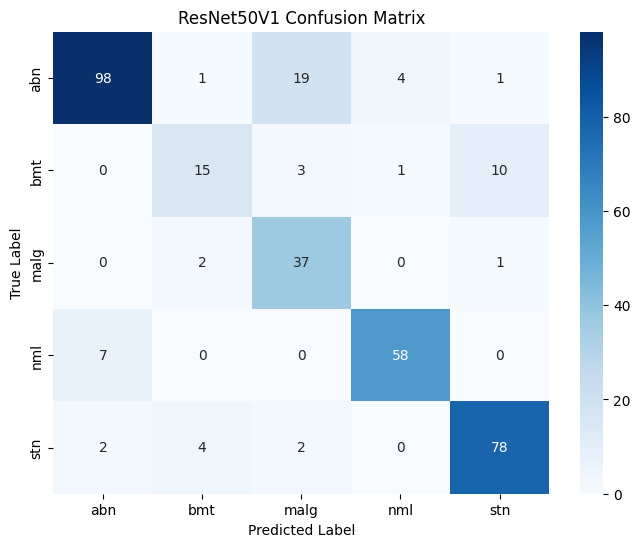

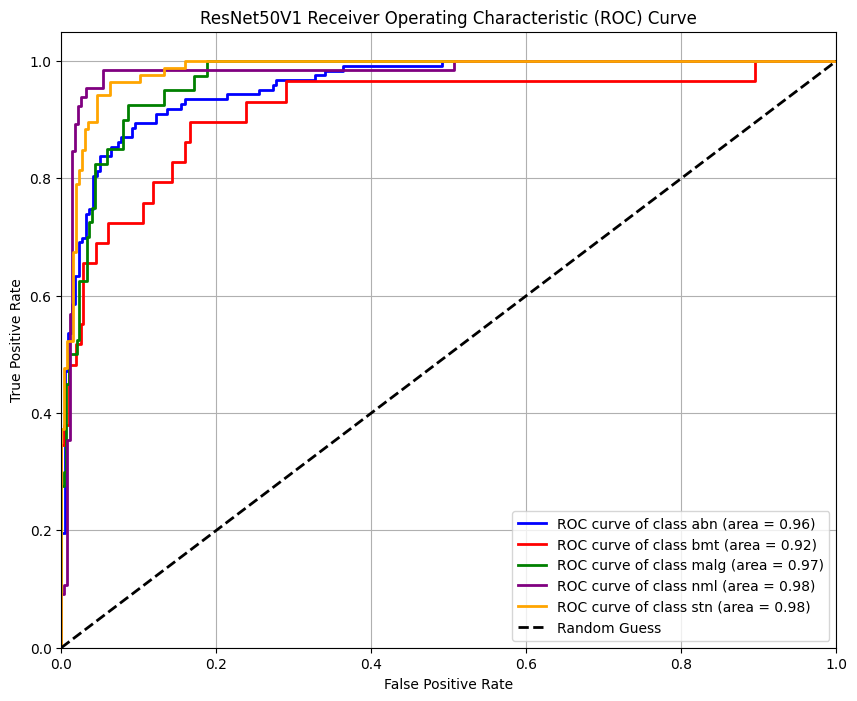

In [41]:
resnet50_v1_model = get_model("resnet50_v1", num_classes=len(class_names))
trained_resnet50_v1_model, train_loss_r50v1, val_loss_r50v1, train_acc_r50v1, val_acc_r50v1 = train_model(resnet50_v1_model, "ResNet50V1", epochs=30, patience=5)
plot_accuracy_loss(train_loss_r50v1, val_loss_r50v1, train_acc_r50v1, val_acc_r50v1, "ResNet50V1")
y_true_r50v1, y_pred_classes_r50v1, y_pred_scores_r50v1 = evaluate_model_on_test(trained_resnet50_v1_model, "ResNet50V1")
plot_confusion_matrix(y_true_r50v1, y_pred_classes_r50v1, class_names, "ResNet50V1")
plot_roc_curve(label_binarize(y_true_r50v1, classes=list(range(NUM_CLASSES))), y_pred_scores_r50v1, NUM_CLASSES, class_names, "ResNet50V1")
all_trained_models.append(trained_resnet50_v1_model)

### ResNet-50 V2


--- Training ResNet50V2 ---
Epoch 0/29
----------
training Loss: 0.9253 Acc: 0.6505
validation Loss: 0.7906 Acc: 0.6532
Epoch 1/29
----------
training Loss: 0.6759 Acc: 0.7321
validation Loss: 0.6196 Acc: 0.7630
Epoch 2/29
----------
training Loss: 0.5852 Acc: 0.7639
validation Loss: 0.6818 Acc: 0.7688
Epoch 3/29
----------
training Loss: 0.5792 Acc: 0.7769
validation Loss: 0.6701 Acc: 0.7428
Epoch 4/29
----------
training Loss: 0.5047 Acc: 0.8100
validation Loss: 0.6714 Acc: 0.7688
Epoch 5/29
----------
training Loss: 0.4994 Acc: 0.8131
validation Loss: 0.5614 Acc: 0.7919
Epoch 6/29
----------
training Loss: 0.4654 Acc: 0.8255
validation Loss: 0.5932 Acc: 0.8064
Epoch 7/29
----------
training Loss: 0.3505 Acc: 0.8660
validation Loss: 0.4217 Acc: 0.8555
Epoch 8/29
----------
training Loss: 0.2793 Acc: 0.8953
validation Loss: 0.4056 Acc: 0.8526
Epoch 9/29
----------
training Loss: 0.2521 Acc: 0.9121
validation Loss: 0.4267 Acc: 0.8439
Epoch 10/29
----------
training Loss: 0.2445 Acc: 0

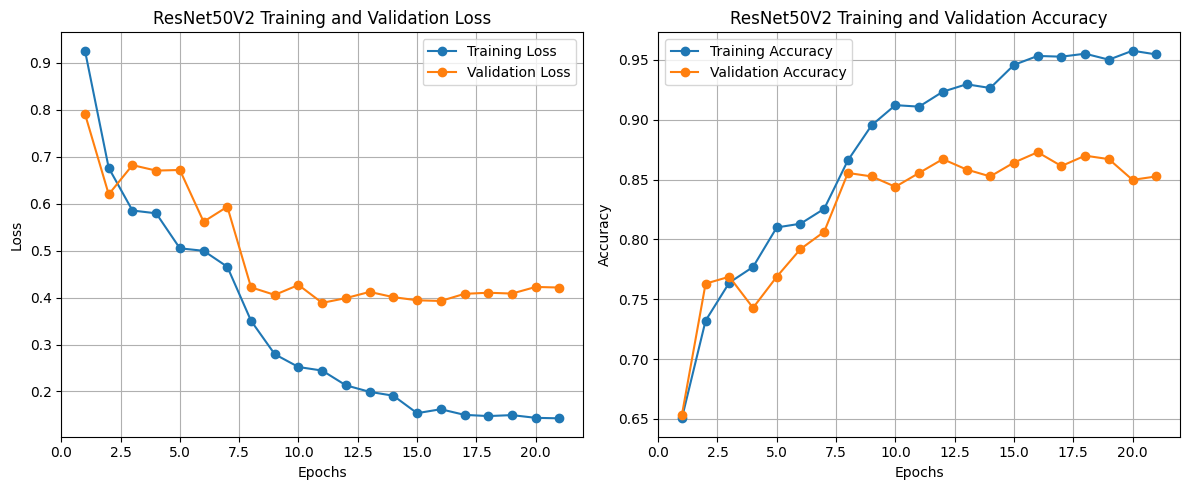


--- Evaluating ResNet50V2 on Test Set ---
Test Accuracy for ResNet50V2: 0.8513
Classification Report for ResNet50V2:
              precision    recall  f1-score   support

         abn       0.91      0.83      0.87       123
         bmt       0.76      0.66      0.70        29
        malg       0.58      0.78      0.67        40
         nml       0.95      0.95      0.95        65
         stn       0.89      0.91      0.90        86

    accuracy                           0.85       343
   macro avg       0.82      0.82      0.82       343
weighted avg       0.86      0.85      0.85       343



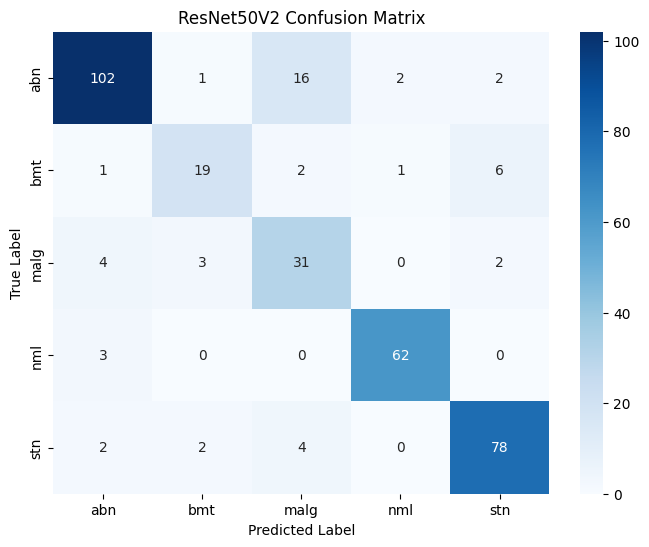

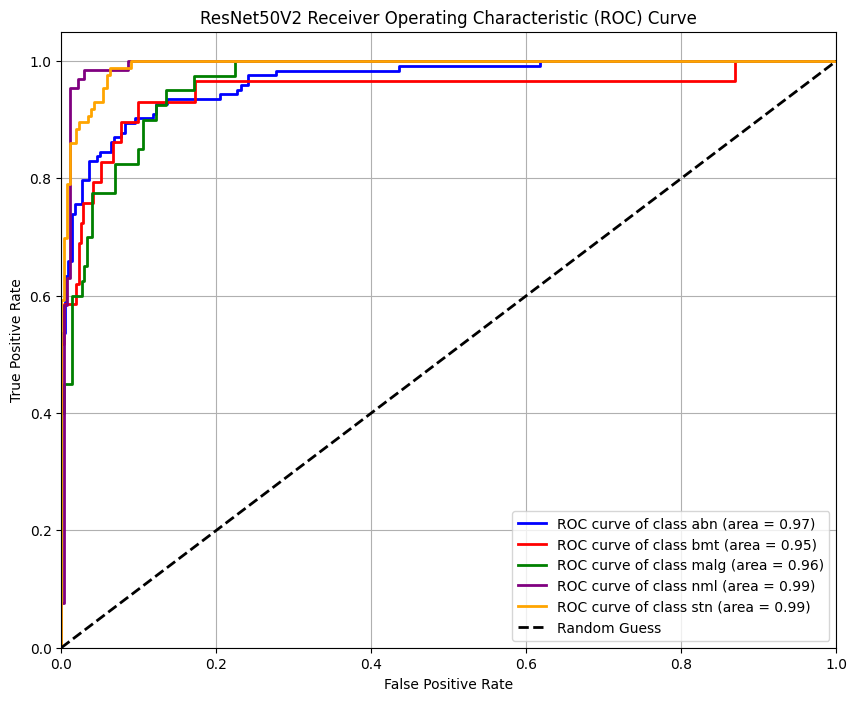

In [42]:
resnet50_v2_model = get_model("resnet50_v2", num_classes=len(class_names))
trained_resnet50_v2_model, train_loss_r50v2, val_loss_r50v2, train_acc_r50v2, val_acc_r50v2 = train_model(resnet50_v2_model, "ResNet50V2", epochs=30, patience=5)
plot_accuracy_loss(train_loss_r50v2, val_loss_r50v2, train_acc_r50v2, val_acc_r50v2, "ResNet50V2")
y_true_r50v2, y_pred_classes_r50v2, y_pred_scores_r50v2 = evaluate_model_on_test(trained_resnet50_v2_model, "ResNet50V2")
plot_confusion_matrix(y_true_r50v2, y_pred_classes_r50v2, class_names, "ResNet50V2")
plot_roc_curve(label_binarize(y_true_r50v2, classes=list(range(NUM_CLASSES))), y_pred_scores_r50v2, NUM_CLASSES, class_names, "ResNet50V2")
all_trained_models.append(trained_resnet50_v2_model)

### GBCNet


--- Training GBCNet ---
Epoch 0/29
----------
training Loss: 1.4955 Acc: 0.3209
validation Loss: 1.4029 Acc: 0.3584
Epoch 1/29
----------
training Loss: 1.3698 Acc: 0.4349
validation Loss: 1.3893 Acc: 0.3988
Epoch 2/29
----------
training Loss: 1.1762 Acc: 0.5302
validation Loss: 1.2162 Acc: 0.4971
Epoch 3/29
----------
training Loss: 1.0437 Acc: 0.5620
validation Loss: 1.0900 Acc: 0.5462
Epoch 4/29
----------
training Loss: 0.9356 Acc: 0.5988
validation Loss: 1.1401 Acc: 0.5578
Epoch 5/29
----------
training Loss: 0.8743 Acc: 0.6399
validation Loss: 0.8150 Acc: 0.6763
Epoch 6/29
----------
training Loss: 0.7919 Acc: 0.6685
validation Loss: 0.8246 Acc: 0.6908
Epoch 7/29
----------
training Loss: 0.6914 Acc: 0.7047
validation Loss: 0.7324 Acc: 0.7254
Epoch 8/29
----------
training Loss: 0.6637 Acc: 0.7321
validation Loss: 0.7149 Acc: 0.7428
Epoch 9/29
----------
training Loss: 0.6561 Acc: 0.7371
validation Loss: 0.7168 Acc: 0.7283
Epoch 10/29
----------
training Loss: 0.6459 Acc: 0.740

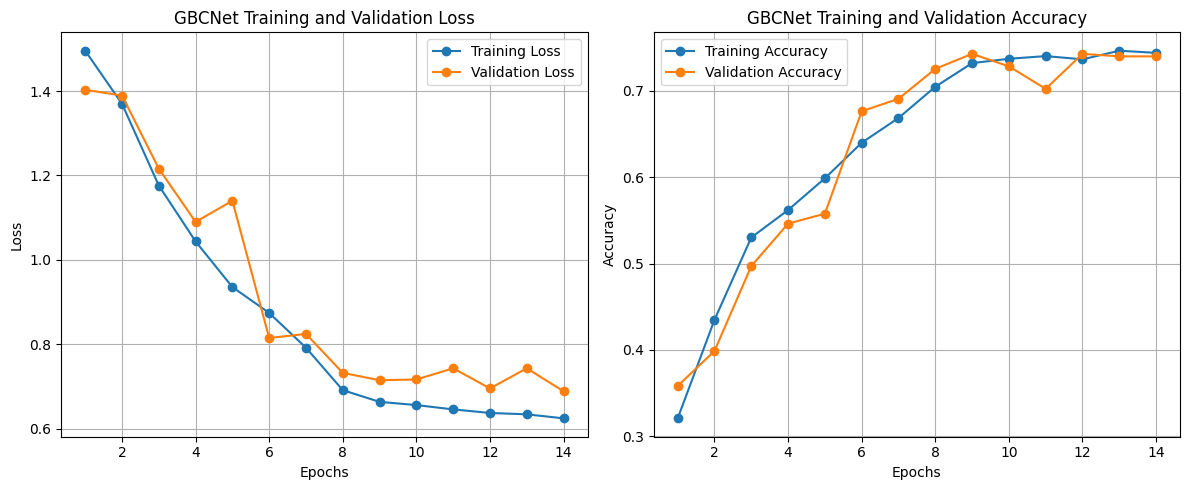


--- Evaluating GBCNet on Test Set ---
Test Accuracy for GBCNet: 0.7405
Classification Report for GBCNet:
              precision    recall  f1-score   support

         abn       0.73      0.82      0.77       123
         bmt       0.60      0.31      0.41        29
        malg       0.72      0.45      0.55        40
         nml       0.78      0.72      0.75        65
         stn       0.75      0.92      0.83        86

    accuracy                           0.74       343
   macro avg       0.72      0.64      0.66       343
weighted avg       0.73      0.74      0.73       343



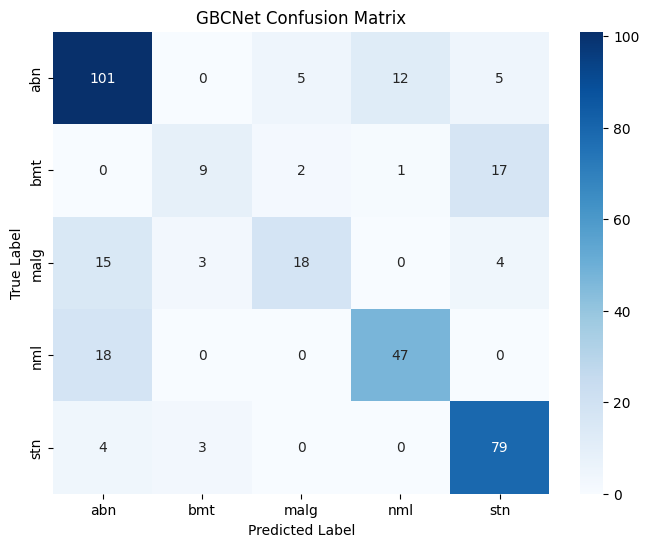

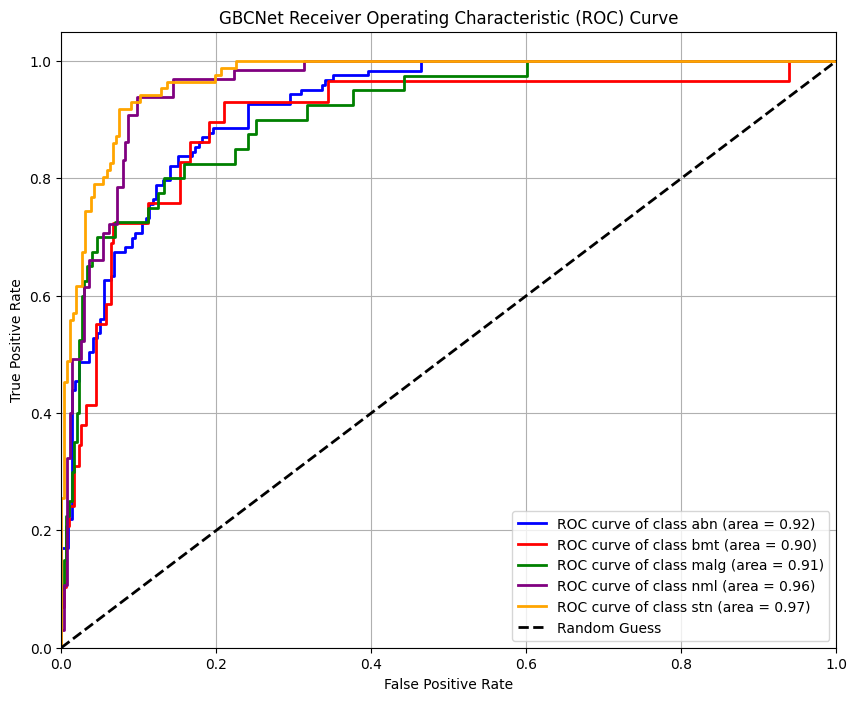

In [43]:
gbcnet_model = get_model("gbcnet", num_classes=len(class_names))
trained_gbcnet_model, train_loss_gbc, val_loss_gbc, train_acc_gbc, val_acc_gbc = train_model(gbcnet_model, "GBCNet", epochs=30, patience=5)
plot_accuracy_loss(train_loss_gbc, val_loss_gbc, train_acc_gbc, val_acc_gbc, "GBCNet")
y_true_gbc, y_pred_classes_gbc, y_pred_scores_gbc = evaluate_model_on_test(trained_gbcnet_model, "GBCNet")
plot_confusion_matrix(y_true_gbc, y_pred_classes_gbc, class_names, "GBCNet")
plot_roc_curve(label_binarize(y_true_gbc, classes=list(range(NUM_CLASSES))), y_pred_scores_gbc, NUM_CLASSES, class_names, "GBCNet")
all_trained_models.append(trained_gbcnet_model)

### RadFormer


--- Training RadFormer ---
Epoch 0/29
----------
training Loss: 2.0619 Acc: 0.3121
validation Loss: 1.4719 Acc: 0.3960
Epoch 1/29
----------
training Loss: 1.4496 Acc: 0.3819
validation Loss: 1.6969 Acc: 0.2977
Epoch 2/29
----------
training Loss: 1.3558 Acc: 0.4305
validation Loss: 1.5313 Acc: 0.4277
Epoch 3/29
----------
training Loss: 1.2882 Acc: 0.4424
validation Loss: 1.3851 Acc: 0.4769
Epoch 4/29
----------
training Loss: 1.1670 Acc: 0.5153
validation Loss: 1.6763 Acc: 0.3931
Epoch 5/29
----------
training Loss: 1.2533 Acc: 0.4679
validation Loss: 1.3458 Acc: 0.4509
Epoch 6/29
----------
training Loss: 1.1845 Acc: 0.5090
validation Loss: 1.1576 Acc: 0.4971
Epoch 7/29
----------
training Loss: 1.0645 Acc: 0.5396
validation Loss: 1.1520 Acc: 0.5145
Epoch 8/29
----------
training Loss: 0.9866 Acc: 0.5763
validation Loss: 1.1276 Acc: 0.5347
Epoch 9/29
----------
training Loss: 0.9265 Acc: 0.6156
validation Loss: 1.2474 Acc: 0.5087
Epoch 10/29
----------
training Loss: 0.9286 Acc: 0.

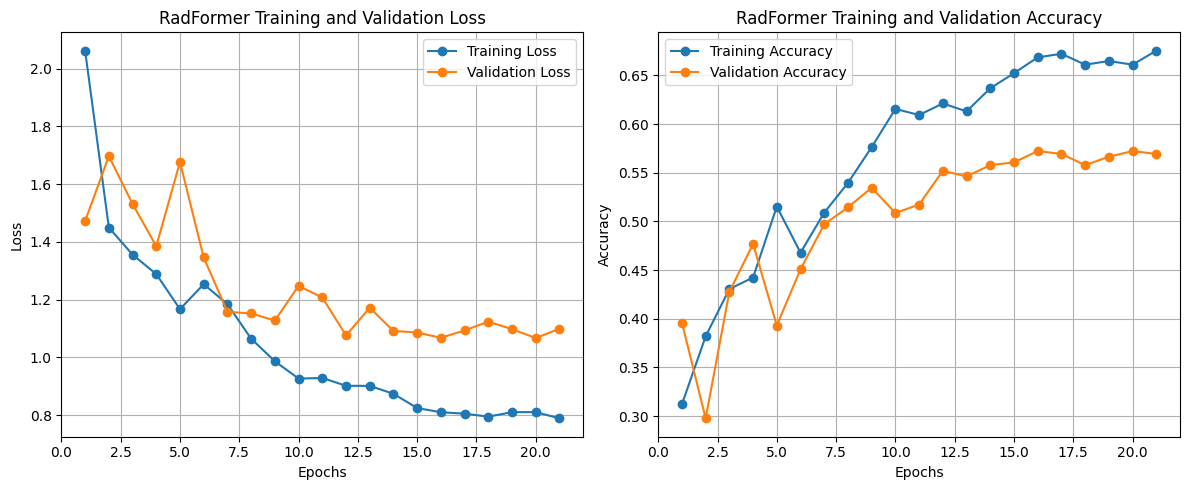


--- Evaluating RadFormer on Test Set ---
Test Accuracy for RadFormer: 0.5860
Classification Report for RadFormer:
              precision    recall  f1-score   support

         abn       0.55      0.77      0.64       123
         bmt       0.55      0.38      0.45        29
        malg       0.69      0.50      0.58        40
         nml       0.44      0.06      0.11        65
         stn       0.63      0.83      0.71        86

    accuracy                           0.59       343
   macro avg       0.57      0.51      0.50       343
weighted avg       0.57      0.59      0.54       343



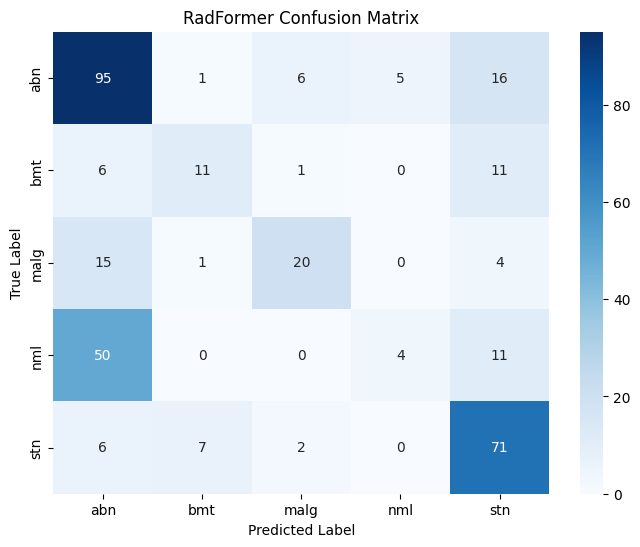

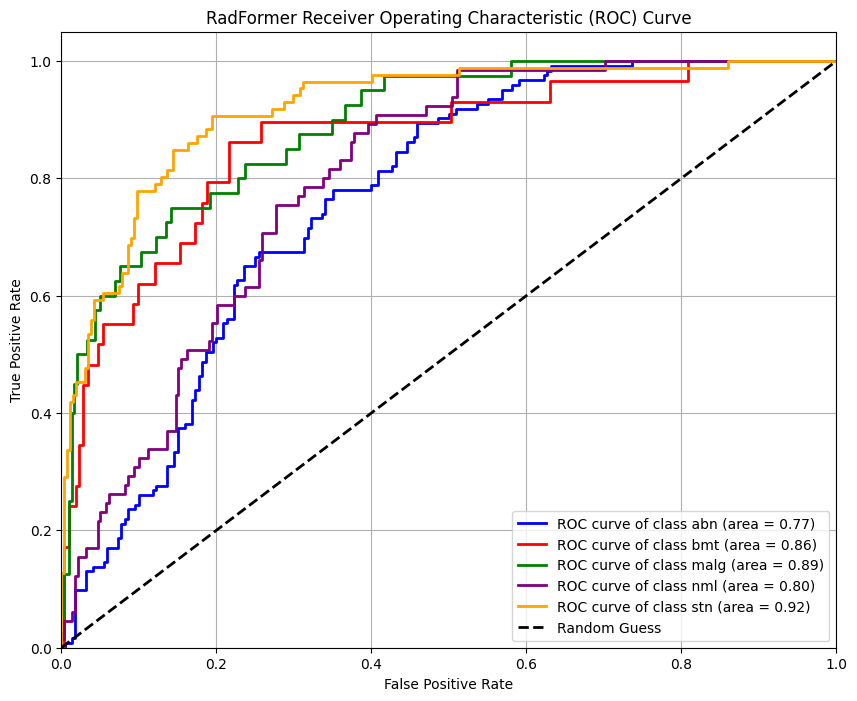

In [44]:
radformer_model = get_model("radformer", num_classes=len(class_names))
trained_radformer_model, train_loss_rad, val_loss_rad, train_acc_rad, val_acc_rad = train_model(radformer_model, "RadFormer", epochs=30, patience=5)
plot_accuracy_loss(train_loss_rad, val_loss_rad, train_acc_rad, val_acc_rad, "RadFormer")
y_true_rad, y_pred_classes_rad, y_pred_scores_rad = evaluate_model_on_test(trained_radformer_model, "RadFormer")
plot_confusion_matrix(y_true_rad, y_pred_classes_rad, class_names, "RadFormer")
plot_roc_curve(label_binarize(y_true_rad, classes=list(range(NUM_CLASSES))), y_pred_scores_rad, NUM_CLASSES, class_names, "RadFormer")
all_trained_models.append(trained_radformer_model)

### Ensemble Evaluation


--- Performing Ensemble Evaluation ---
Ensemble Test Accuracy: 0.8892
Ensemble Classification Report:
              precision    recall  f1-score   support

         abn       0.93      0.88      0.90       123
         bmt       0.83      0.69      0.75        29
        malg       0.71      0.85      0.77        40
         nml       0.94      0.95      0.95        65
         stn       0.91      0.94      0.93        86

    accuracy                           0.89       343
   macro avg       0.86      0.86      0.86       343
weighted avg       0.89      0.89      0.89       343



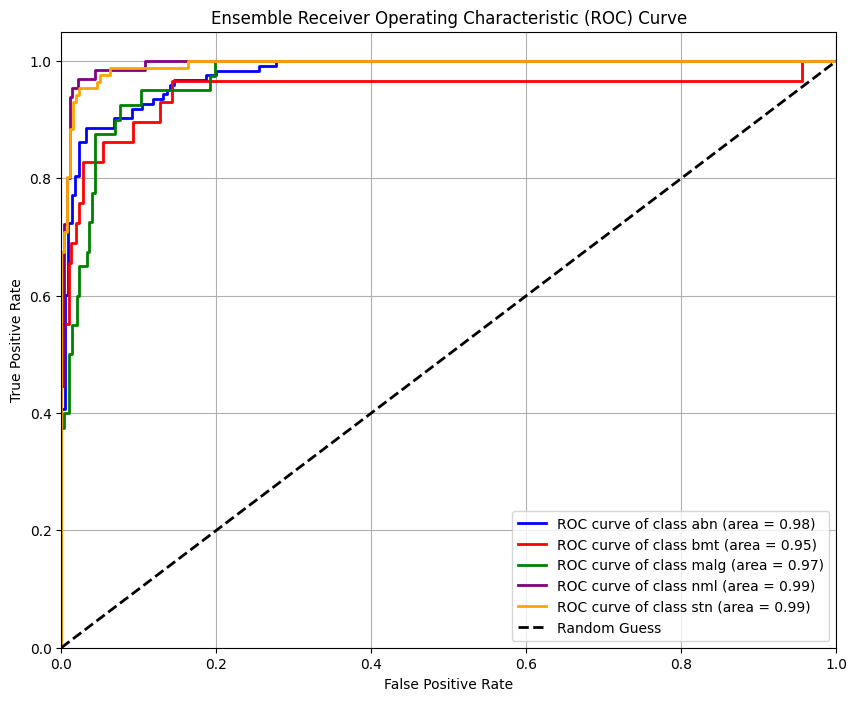

In [45]:
ensemble_accuracy, ensemble_probs, y_true_ensemble = ensemble_evaluate(all_trained_models, test_loader, class_names, device)
model_results["Ensemble"] = ensemble_accuracy
plot_roc_curve(label_binarize(y_true_ensemble, classes=list(range(NUM_CLASSES))), ensemble_probs, NUM_CLASSES, class_names, "Ensemble")

### Table

In [46]:
print("\nModel Performance Summary (Including Ensemble - All Test Accuracies):\\n")
results_df = pd.DataFrame(list(model_results.items()), columns=["Model", "Test Accuracy"])
results_df["Test Accuracy"] = results_df["Test Accuracy"].apply(lambda x: f"{x*100:.2f}%")
results_df = results_df.sort_values(by="Test Accuracy", ascending=False) # Sort by accuracy

print(results_df.to_string(index=False))


Model Performance Summary (Including Ensemble - All Test Accuracies):\n
         Model Test Accuracy
      Ensemble        88.92%
EfficientNetB2        88.63%
EfficientNetB1        87.76%
EfficientNetB3        87.76%
EfficientNetB0        87.46%
EfficientNetB4        86.59%
   MobileNetV2        85.71%
  ShuffleNetV2        85.13%
   DenseNet201        85.13%
    ResNet50V2        85.13%
      ResNet18        84.26%
   DenseNet121        84.26%
    ResNet50V1        83.38%
        GBCNet        74.05%
    SqueezeNet        70.26%
     RadFormer        58.60%


Weights for weighted ensemble: [0.16917028 0.16750969 0.16750969 0.16693707 0.16527648 0.1635968 ]

Weighted Ensemble Test Accuracy: 89.21%
Classification Report:
              precision    recall  f1-score   support

         abn       0.93      0.87      0.90       123
         bmt       0.81      0.72      0.76        29
        malg       0.68      0.85      0.76        40
         nml       0.95      0.95      0.95        65
         stn       0.94      0.95      0.95        86

    accuracy                           0.89       343
   macro avg       0.86      0.87      0.86       343
weighted avg       0.90      0.89      0.89       343



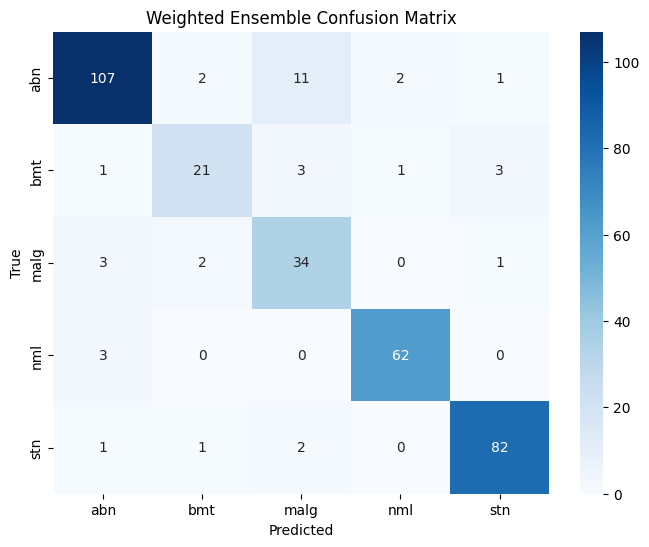

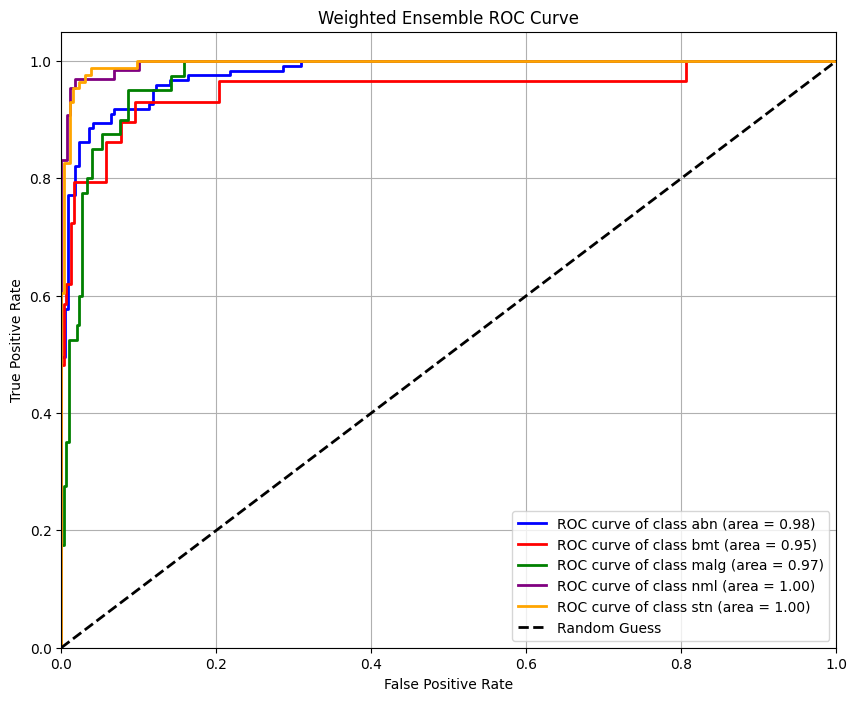

In [47]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------
# Selected models and weights
# --------------------------
selected_models = [
    ("EfficientNetB2", efficientnet_b2_model),
    ("EfficientNetB1", efficientnet_b1_model),
    ("EfficientNetB3", efficientnet_b3_model),
    ("EfficientNetB0", efficientnet_b0_model),
    ("EfficientNetB4", efficientnet_b4_model),
    ("MobileNetV2", mobilenet_v2_model)
]

# Test accuracies of selected models
selected_accs = np.array([0.8863, 0.8776, 0.8776, 0.8746, 0.8659, 0.8571])
weights = selected_accs / selected_accs.sum()
print("Weights for weighted ensemble:", weights)

# --------------------------
# Weighted Ensemble Prediction
# --------------------------
def weighted_ensemble_predict(models, weights, test_loader, device):
    all_preds = []
    y_true = []
    weighted_probs_list = []

    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        y_true.extend(labels.cpu().numpy())

        # Weighted probability sum
        weighted_probs = 0
        for (name, model), w in zip(models, weights):
            model.eval()
            with torch.no_grad():
                outputs = model(inputs)
                probs = torch.softmax(outputs, dim=1).cpu().numpy()
                weighted_probs += w * probs

        weighted_probs_list.extend(weighted_probs)
        all_preds.extend(np.argmax(weighted_probs, axis=1))

    ensemble_accuracy = accuracy_score(y_true, all_preds)
    print(f"\nWeighted Ensemble Test Accuracy: {ensemble_accuracy*100:.2f}%")
    print(f"Classification Report:\n{classification_report(y_true, all_preds, target_names=class_names)}")

    return ensemble_accuracy, all_preds, np.array(weighted_probs_list), y_true

# Run weighted ensemble
ensemble_accuracy, ensemble_preds, ensemble_probs, y_true_ensemble = weighted_ensemble_predict(
    selected_models, weights, test_loader, device
)

# --------------------------
# Plot Confusion Matrix
# --------------------------
def plot_confusion_matrix(y_true, y_pred, class_names, model_name="Weighted Ensemble"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(y_true_ensemble, ensemble_preds, class_names, "Weighted Ensemble")

# --------------------------
# Plot ROC Curve
# --------------------------
def plot_roc_curve(y_true, y_pred_probs, class_names, model_name="Weighted Ensemble"):
    n_classes = len(class_names)
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10,8))
    colors = ['blue', 'red', 'green', 'purple', 'orange']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0,1], [0,1], 'k--', lw=2, label='Random Guess')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

plot_roc_curve(y_true_ensemble, ensemble_probs, class_names, "Weighted Ensemble")